In [1]:
# imports
import torch
import ray
import os
import shutil
import matplotlib.pyplot as plt

from DataObjects.DataLoader import DataLoader
from Architectures.Transformer.GPT2 import GPT2FineTuner
from ray import tune
from ray.tune.schedulers import ASHAScheduler
from ray.air import session

from pathlib import Path
import numpy as np

/home/piotr/PycharmProjects/dl_project1/DeepLearning/Project_II/.venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-04-26 19:08:02,229	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-04-26 19:08:04,238	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [2]:
# SETTING SEED
SEED = 42069    
torch.manual_seed(SEED)
np.random.seed(0)

In [3]:
# set device to cuda
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [4]:
def train_gpt2(config, audio_dim, num_labels, device):
    # Initialize GPT2 model with parameters from Ray Tune's search space
    model = GPT2FineTuner(
        audio_dim=audio_dim,
        num_labels=num_labels,
        pretrained=True,
        model_name="gpt2",
        lr=config["lr"],  # Hyperparameter from Ray Tune
    ).to(device)

    train_loader = DataLoader(
    data_dir=config["train_dir"],
    data_type='mfcc',
    batch_size=config["batch_size"],
    shuffle=True
    )
    val_loader = DataLoader(
    data_dir=config["val_dir"],
    data_type='mfcc',
    batch_size=config["batch_size"],
    shuffle=True
    )

    # Training loop
    model.train_architecture(train_loader=train_loader, val_loader=val_loader, epochs=config["epochs"])

    # Evaluate the model
    results = model.evaluate(val_loader)

    final_loss = results["summary"]["loss"]
    final_acc = results["summary"]["accuracy"]

    # Report the validation accuracy or other metrics as the result
    if not session.get_session():
        return final_loss, final_acc
    return None

In [5]:
DATA_PATH = Path("Data")

In [6]:
@ray.remote
def setup_worker():
    """Ensure each Ray worker has access to the dataset."""
    worker_data_path = os.path.join(os.getcwd(), "worker_data")

    if not os.path.exists(worker_data_path):
        os.makedirs(worker_data_path)

    # Copy dataset if it doesn’t already exist
    source_data_path = os.path.abspath("Data/MFCC_transformed")
    if not os.path.exists(os.path.join(worker_data_path, "MFCC_transformed")):
        shutil.copytree(source_data_path, os.path.join(worker_data_path, "MFCC_transformed"))

    return f"Worker setup complete: {worker_data_path}"

In [7]:
config = {
    "lr": tune.loguniform(1e-5, 1e-3),  # Learning rate search space
    "epochs": tune.choice([1, 3, 5, 7]), # Number of epochs to train
    "batch_size": tune.choice([4, 16, 32, 64]), # Batch size choice
    "train_dir": os.path.abspath("Data/MFCC_transformed/training"),
    "val_dir":  os.path.abspath("Data/MFCC_transformed/validation")
}

In [8]:
# Set up a scheduler for early stopping based on validation accuracy
scheduler = ASHAScheduler(
    metric="accuracy",  # Objective metric
    mode="max",         # We want to maximize accuracy
    max_t=10,           # Maximum number of epochs to run
    grace_period=2,     # Number of epochs to wait before evaluating
    reduction_factor=2  # Reduce the number of trials as we progress
)

In [9]:
# prepare Data Loader files
train_dir = DATA_PATH / Path("MFCC_transformed", "training")
val_dir = DATA_PATH / Path("MFCC_transformed", "validation")
test_dir = DATA_PATH / Path("MFCC_transformed", "testing")

batch_size = 64

train_loader = DataLoader(
    data_dir=train_dir,
    data_type='mfcc',
    batch_size=batch_size,
    shuffle=True
)
val_loader = DataLoader(
    data_dir=val_dir,
    data_type='mfcc',
    batch_size=batch_size,
    shuffle=True
)

test_loader = DataLoader(
    data_dir=test_dir,
    data_type='mfcc',
    batch_size=batch_size,
    shuffle=True
)

# Inspect class mapping and dataset size
print("Classes:", train_loader.class_to_idx)
print("# training batches:", len(train_loader))

print("# validation batches:", len(val_loader))

print("# testing batches:", len(test_loader))

Classes: {'bed': 0, 'bird': 1, 'cat': 2, 'dog': 3, 'down': 4, 'eight': 5, 'five': 6, 'four': 7, 'go': 8, 'happy': 9, 'house': 10, 'left': 11, 'marvin': 12, 'nine': 13, 'no': 14, 'off': 15, 'on': 16, 'one': 17, 'right': 18, 'seven': 19, 'sheila': 20, 'silence': 21, 'six': 22, 'stop': 23, 'three': 24, 'tree': 25, 'two': 26, 'up': 27, 'wow': 28, 'yes': 29, 'zero': 30}
# training batches: 797
# validation batches: 108
# testing batches: 108


In [10]:
batch = next(iter(train_loader))
C, *rest = batch.data.shape[1:] 
audio_dim = C                     

num_labels = len(train_loader.class_to_idx)

In [11]:
ray.init(ignore_reinit_error=True)
ray.get(setup_worker.remote())

trainable = tune.with_parameters(train_gpt2, audio_dim=audio_dim, num_labels=num_labels, device=device)

trainable = tune.with_resources(trainable, resources={"cpu": 16, "gpu": 1})

tuner = tune.Tuner(
    trainable,
    param_space=config,
    tune_config=tune.TuneConfig(
        scheduler=scheduler,
        num_samples=20,
    ),
)

results = tuner.fit()

best_result = results.get_best_result(metric="accuracy", mode="max")
best_config = best_result.config
print("Best config: ", best_config)

(raylet) [2025-04-26 19:08:15,600 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.05902 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
(raylet) [2025-04-26 19:08:25,603 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.05899 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
(raylet) [2025-04-26 19:08:35,605 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.05897 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
(raylet) [2025-04-26 19:08:45,608 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.05897 GB; capacity: 95.4532 GB. Object creation

(train_gpt2 pid=159540) Epoch 1/3 - train loss: 0.9770 - train acc: 0.7121


Evaluating GPT2: 100%|██████████| 431/431 [00:08<00:00, 50.35it/s]
(train_gpt2 pid=159540) /home/piotr/PycharmProjects/dl_project1/DeepLearning/Project_II/.venv/lib/python3.10/site-packages/ray/train/_internal/session.py:772: RayDeprecationWarning: `ray.train.report` should be switched to `ray.tune.report` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context: https://github.com/ray-project/ray/issues/49454
(train_gpt2 pid=159540)   _log_deprecation_warning(


(train_gpt2 pid=159540) Epoch 1/3 - val loss: 0.4316 - val acc: 0.8721 - val prec: 0.8875 - val rec: 0.8729 - val f1: 0.8772


(raylet) [2025-04-26 19:11:55,666 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.05865 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
(raylet) [2025-04-26 19:12:05,669 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.05856 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
(raylet) [2025-04-26 19:12:15,673 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.05854 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
(raylet) [2025-04-26 19:12:25,677 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.05853 GB; capacity: 95.4532 GB. Object creation

(train_gpt2 pid=159540) Epoch 2/3 - train loss: 0.3496 - train acc: 0.8962


Evaluating GPT2:  84%|████████▍ | 361/431 [00:07<00:01, 51.08it/s]
(raylet) [2025-04-26 19:15:25,744 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.05807 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
Evaluating GPT2: 100%|██████████| 431/431 [00:08<00:00, 50.71it/s]
(train_gpt2 pid=159540) /home/piotr/PycharmProjects/dl_project1/DeepLearning/Project_II/.venv/lib/python3.10/site-packages/ray/train/_internal/session.py:772: RayDeprecationWarning: `ray.train.report` should be switched to `ray.tune.report` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context: https://github.com/ray-project/ray/issues/49454
(train_gpt2 pid=159540)   _log_deprecation_warning(


(train_gpt2 pid=159540) Epoch 2/3 - val loss: 0.3310 - val acc: 0.8997 - val prec: 0.9074 - val rec: 0.9016 - val f1: 0.9017


(raylet) [2025-04-26 19:15:35,751 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.05806 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
(raylet) [2025-04-26 19:15:45,757 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.05806 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
(raylet) [2025-04-26 19:15:55,760 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.05806 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
(raylet) [2025-04-26 19:16:05,763 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.05799 GB; capacity: 95.4532 GB. Object creation

(train_gpt2 pid=159540) Epoch 3/3 - train loss: 0.2704 - train acc: 0.9209


Evaluating GPT2:  59%|█████▉    | 256/431 [00:05<00:03, 50.24it/s]
(raylet) [2025-04-26 19:18:55,819 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.05816 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
Evaluating GPT2: 100%|██████████| 431/431 [00:08<00:00, 50.73it/s]
(train_gpt2 pid=159540) /home/piotr/PycharmProjects/dl_project1/DeepLearning/Project_II/.venv/lib/python3.10/site-packages/ray/train/_internal/session.py:772: RayDeprecationWarning: `ray.train.report` should be switched to `ray.tune.report` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context: https://github.com/ray-project/ray/issues/49454
(train_gpt2 pid=159540)   _log_deprecation_warning(
Evaluating GPT2:   0%|          | 0/431 [00:00<?, ?it/s]


(train_gpt2 pid=159540) Epoch 3/3 - val loss: 0.3138 - val acc: 0.9073 - val prec: 0.9142 - val rec: 0.9087 - val f1: 0.9094


Evaluating GPT2:  77%|███████▋  | 334/431 [00:06<00:01, 49.01it/s]
(raylet) [2025-04-26 19:19:05,822 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.05807 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
Evaluating GPT2: 100%|██████████| 431/431 [00:08<00:00, 50.18it/s]
(raylet) [2025-04-26 19:19:15,826 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.05798 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
(raylet) [2025-04-26 19:19:25,831 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.05796 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
(raylet) [2025-04-26 19:19:35,835 E 158602 158632] (raylet) file_system_monitor.cc:116: /

(train_gpt2 pid=160016) Epoch 1/5 - train loss: 1.7290 - train acc: 0.5003


Evaluating GPT2:  27%|██▋       | 467/1722 [00:04<00:11, 111.92it/s]
(raylet) [2025-04-26 19:25:55,978 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.05731 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
Evaluating GPT2:  93%|█████████▎| 1595/1722 [00:14<00:01, 112.79it/s]
(raylet) [2025-04-26 19:26:05,982 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.05723 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
Evaluating GPT2: 100%|██████████| 1722/1722 [00:15<00:00, 112.24it/s]
(train_gpt2 pid=160016) /home/piotr/PycharmProjects/dl_project1/DeepLearning/Project_II/.venv/lib/python3.10/site-packages/ray/train/_internal/session.py:772: RayDeprecationWarning: `ray.train.report` should be switched to `ray.tune.report` when running in a function passe

(train_gpt2 pid=160016) Epoch 1/5 - val loss: 0.6540 - val acc: 0.8044 - val prec: 0.8106 - val rec: 0.8073 - val f1: 0.8058


(raylet) [2025-04-26 19:26:15,986 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.05718 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
(raylet) [2025-04-26 19:26:25,989 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.06686 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
(raylet) [2025-04-26 19:26:35,993 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.06541 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
(raylet) [2025-04-26 19:26:45,998 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.06541 GB; capacity: 95.4532 GB. Object creation

(train_gpt2 pid=160016) Epoch 2/5 - train loss: 0.4243 - train acc: 0.8748


Evaluating GPT2:  47%|████▋     | 804/1722 [00:07<00:08, 112.43it/s]
(raylet) [2025-04-26 19:32:46,129 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.06475 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
Evaluating GPT2: 100%|██████████| 1722/1722 [00:15<00:00, 112.38it/s]
(train_gpt2 pid=160016) /home/piotr/PycharmProjects/dl_project1/DeepLearning/Project_II/.venv/lib/python3.10/site-packages/ray/train/_internal/session.py:772: RayDeprecationWarning: `ray.train.report` should be switched to `ray.tune.report` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context: https://github.com/ray-project/ray/issues/49454
(train_gpt2 pid=160016)   _log_deprecation_warning(


(train_gpt2 pid=160016) Epoch 2/5 - val loss: 0.4068 - val acc: 0.8767 - val prec: 0.8912 - val rec: 0.8778 - val f1: 0.8809


(raylet) [2025-04-26 19:32:56,133 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.0647 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
(raylet) [2025-04-26 19:33:06,137 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.06461 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
(raylet) [2025-04-26 19:33:16,140 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.06459 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
(raylet) [2025-04-26 19:33:26,144 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.06458 GB; capacity: 95.4532 GB. Object creation 

(train_gpt2 pid=161513) Epoch 1/1 - train loss: 1.2917 - train acc: 0.6227


Evaluating GPT2:  49%|████▉     | 851/1722 [00:07<00:07, 112.43it/s]
(raylet) [2025-04-26 19:39:46,289 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.06393 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
Evaluating GPT2: 100%|█████████▉| 1715/1722 [00:15<00:00, 112.14it/s]


(train_gpt2 pid=161513) Epoch 1/1 - val loss: 0.5931 - val acc: 0.8262 - val prec: 0.8360 - val rec: 0.8294 - val f1: 0.8276


Evaluating GPT2: 100%|██████████| 1722/1722 [00:15<00:00, 112.13it/s]
(train_gpt2 pid=161513) /home/piotr/PycharmProjects/dl_project1/DeepLearning/Project_II/.venv/lib/python3.10/site-packages/ray/train/_internal/session.py:772: RayDeprecationWarning: `ray.train.report` should be switched to `ray.tune.report` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context: https://github.com/ray-project/ray/issues/49454
(train_gpt2 pid=161513)   _log_deprecation_warning(
Evaluating GPT2:  14%|█▍        | 239/1722 [00:02<00:13, 112.28it/s]
(raylet) [2025-04-26 19:39:56,293 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.06388 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
Evaluating GPT2:  79%|███████▉  | 1357/1722 [00:12<00:03, 111.16it/s]
(raylet) [2025-04-26 19:40:06,297 E 158602 158632] (raylet) file_system_mo

(train_gpt2 pid=161727) Epoch 1/1 - train loss: 3.4095 - train acc: 0.0541


Evaluating GPT2:  28%|██▊       | 30/108 [00:02<00:05, 13.07it/s]
(raylet) [2025-04-26 19:43:06,363 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.06336 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
Evaluating GPT2:  98%|█████████▊| 106/108 [00:08<00:00, 13.18it/s]


(train_gpt2 pid=161727) Epoch 1/1 - val loss: 3.1708 - val acc: 0.1037 - val prec: 0.0931 - val rec: 0.0936 - val f1: 0.0637


Evaluating GPT2: 100%|██████████| 108/108 [00:08<00:00, 13.11it/s]
(train_gpt2 pid=161727) /home/piotr/PycharmProjects/dl_project1/DeepLearning/Project_II/.venv/lib/python3.10/site-packages/ray/train/_internal/session.py:772: RayDeprecationWarning: `ray.train.report` should be switched to `ray.tune.report` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context: https://github.com/ray-project/ray/issues/49454
(train_gpt2 pid=161727)   _log_deprecation_warning(
Evaluating GPT2:  50%|█████     | 54/108 [00:04<00:04, 13.04it/s]
(raylet) [2025-04-26 19:43:16,368 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.0555 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
Evaluating GPT2: 100%|██████████| 108/108 [00:08<00:00, 13.12it/s]
(raylet) [2025-04-26 19:43:26,371 E 158602 158632] (raylet) file_system_monitor.cc:1

(train_gpt2 pid=162521) Epoch 1/3 - train loss: 1.0659 - train acc: 0.6887


Evaluating GPT2:  33%|███▎      | 564/1722 [00:04<00:10, 113.01it/s]
(raylet) [2025-04-26 19:50:06,525 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.05447 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
Evaluating GPT2:  98%|█████████▊| 1692/1722 [00:15<00:00, 113.01it/s]
(raylet) [2025-04-26 19:50:16,529 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.05445 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
Evaluating GPT2:  99%|█████████▉| 1704/1722 [00:15<00:00, 112.77it/s]


(train_gpt2 pid=162521) Epoch 1/3 - val loss: 0.5262 - val acc: 0.8548 - val prec: 0.8691 - val rec: 0.8557 - val f1: 0.8584


Evaluating GPT2: 100%|██████████| 1722/1722 [00:15<00:00, 112.81it/s]
(train_gpt2 pid=162521) /home/piotr/PycharmProjects/dl_project1/DeepLearning/Project_II/.venv/lib/python3.10/site-packages/ray/train/_internal/session.py:772: RayDeprecationWarning: `ray.train.report` should be switched to `ray.tune.report` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context: https://github.com/ray-project/ray/issues/49454
(train_gpt2 pid=162521)   _log_deprecation_warning(
(raylet) [2025-04-26 19:50:26,533 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.05441 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
(raylet) [2025-04-26 19:50:36,537 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.0544 GB; capacity: 95.4532 GB. Object

(train_gpt2 pid=162521) Epoch 2/3 - train loss: 0.3309 - train acc: 0.9018


Evaluating GPT2:  15%|█▍        | 252/1722 [00:02<00:12, 113.12it/s]
(raylet) [2025-04-26 19:56:46,673 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.05359 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
Evaluating GPT2:  80%|████████  | 1380/1722 [00:12<00:03, 112.47it/s]
(raylet) [2025-04-26 19:56:56,677 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.05357 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
Evaluating GPT2: 100%|█████████▉| 1716/1722 [00:15<00:00, 112.73it/s]


(train_gpt2 pid=162521) Epoch 2/3 - val loss: 0.3233 - val acc: 0.9049 - val prec: 0.9152 - val rec: 0.9051 - val f1: 0.9076


Evaluating GPT2: 100%|██████████| 1722/1722 [00:15<00:00, 112.97it/s]
(train_gpt2 pid=162521) /home/piotr/PycharmProjects/dl_project1/DeepLearning/Project_II/.venv/lib/python3.10/site-packages/ray/train/_internal/session.py:772: RayDeprecationWarning: `ray.train.report` should be switched to `ray.tune.report` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context: https://github.com/ray-project/ray/issues/49454
(train_gpt2 pid=162521)   _log_deprecation_warning(
(raylet) [2025-04-26 19:57:06,681 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.05348 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
(raylet) [2025-04-26 19:57:16,686 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.05346 GB; capacity: 95.4532 GB. Objec

(train_gpt2 pid=162521) Epoch 3/3 - train loss: 0.2233 - train acc: 0.9330


Evaluating GPT2:  62%|██████▏   | 1068/1722 [00:09<00:05, 113.72it/s]
(raylet) [2025-04-26 20:03:36,829 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.0526 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
Evaluating GPT2: 100%|██████████| 1722/1722 [00:15<00:00, 113.46it/s]
(train_gpt2 pid=162521) /home/piotr/PycharmProjects/dl_project1/DeepLearning/Project_II/.venv/lib/python3.10/site-packages/ray/train/_internal/session.py:772: RayDeprecationWarning: `ray.train.report` should be switched to `ray.tune.report` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context: https://github.com/ray-project/ray/issues/49454
(train_gpt2 pid=162521)   _log_deprecation_warning(
Evaluating GPT2:   0%|          | 0/1722 [00:00<?, ?it/s]


(train_gpt2 pid=162521) Epoch 3/3 - val loss: 0.2648 - val acc: 0.9179 - val prec: 0.9268 - val rec: 0.9188 - val f1: 0.9212


Evaluating GPT2:  28%|██▊       | 480/1722 [00:04<00:11, 111.82it/s]
(raylet) [2025-04-26 20:03:46,832 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.05259 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
Evaluating GPT2:  93%|█████████▎| 1596/1722 [00:14<00:01, 112.48it/s]
(raylet) [2025-04-26 20:03:56,836 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.05258 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
Evaluating GPT2: 100%|██████████| 1722/1722 [00:15<00:00, 112.92it/s]
(raylet) [2025-04-26 20:04:06,840 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.05243 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
(raylet) [2025

(train_gpt2 pid=169597) Epoch 1/1 - train loss: 1.2247 - train acc: 0.6424


Evaluating GPT2:  65%|██████▍   | 70/108 [00:05<00:02, 13.00it/s]
(raylet) [2025-04-26 20:06:56,904 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.05219 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
Evaluating GPT2: 100%|██████████| 108/108 [00:08<00:00, 13.18it/s]
(train_gpt2 pid=169597) /home/piotr/PycharmProjects/dl_project1/DeepLearning/Project_II/.venv/lib/python3.10/site-packages/ray/train/_internal/session.py:772: RayDeprecationWarning: `ray.train.report` should be switched to `ray.tune.report` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context: https://github.com/ray-project/ray/issues/49454
(train_gpt2 pid=169597)   _log_deprecation_warning(
Evaluating GPT2:   0%|          | 0/108 [00:00<?, ?it/s]


(train_gpt2 pid=169597) Epoch 1/1 - val loss: 0.4801 - val acc: 0.8527 - val prec: 0.8672 - val rec: 0.8546 - val f1: 0.8566


Evaluating GPT2:  87%|████████▋ | 94/108 [00:07<00:01, 13.05it/s]
(raylet) [2025-04-26 20:07:06,908 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.05207 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
Evaluating GPT2: 100%|██████████| 108/108 [00:08<00:00, 13.15it/s]
(raylet) [2025-04-26 20:07:16,911 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.052 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
(raylet) [2025-04-26 20:07:26,916 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.05199 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
(raylet) [2025-04-26 20:07:36,920 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp

(train_gpt2 pid=169777) Epoch 1/3 - train loss: 1.2855 - train acc: 0.6284


Evaluating GPT2: 100%|██████████| 431/431 [00:08<00:00, 52.05it/s]
(train_gpt2 pid=169777) /home/piotr/PycharmProjects/dl_project1/DeepLearning/Project_II/.venv/lib/python3.10/site-packages/ray/train/_internal/session.py:772: RayDeprecationWarning: `ray.train.report` should be switched to `ray.tune.report` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context: https://github.com/ray-project/ray/issues/49454
(train_gpt2 pid=169777)   _log_deprecation_warning(


(train_gpt2 pid=169777) Epoch 1/3 - val loss: 0.5645 - val acc: 0.8353 - val prec: 0.8233 - val rec: 0.8086 - val f1: 0.8112


(raylet) [2025-04-26 20:10:56,997 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.05149 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
(raylet) [2025-04-26 20:11:07,001 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.05138 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
(raylet) [2025-04-26 20:11:17,005 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.05137 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
(raylet) [2025-04-26 20:11:27,008 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.05136 GB; capacity: 95.4532 GB. Object creation

(train_gpt2 pid=169777) Epoch 2/3 - train loss: 0.3443 - train acc: 0.8982


Evaluating GPT2:  97%|█████████▋| 420/431 [00:08<00:00, 52.27it/s]
(raylet) [2025-04-26 20:14:27,074 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.05106 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
Evaluating GPT2: 100%|██████████| 431/431 [00:08<00:00, 52.20it/s]
(train_gpt2 pid=169777) /home/piotr/PycharmProjects/dl_project1/DeepLearning/Project_II/.venv/lib/python3.10/site-packages/ray/train/_internal/session.py:772: RayDeprecationWarning: `ray.train.report` should be switched to `ray.tune.report` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context: https://github.com/ray-project/ray/issues/49454
(train_gpt2 pid=169777)   _log_deprecation_warning(


(train_gpt2 pid=169777) Epoch 2/3 - val loss: 0.3340 - val acc: 0.8992 - val prec: 0.9059 - val rec: 0.9026 - val f1: 0.9020


(raylet) [2025-04-26 20:14:37,078 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.05098 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
(raylet) [2025-04-26 20:14:47,082 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.05097 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
(raylet) [2025-04-26 20:14:57,086 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.05097 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
(raylet) [2025-04-26 20:15:07,089 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.05089 GB; capacity: 95.4532 GB. Object creation

(train_gpt2 pid=170180) Epoch 1/7 - train loss: 2.4698 - train acc: 0.2918


Evaluating GPT2:  72%|███████▏  | 156/216 [00:06<00:02, 25.75it/s]
(raylet) [2025-04-26 20:17:37,144 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.05066 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
Evaluating GPT2: 100%|██████████| 216/216 [00:08<00:00, 25.87it/s]
(train_gpt2 pid=170180) /home/piotr/PycharmProjects/dl_project1/DeepLearning/Project_II/.venv/lib/python3.10/site-packages/ray/train/_internal/session.py:772: RayDeprecationWarning: `ray.train.report` should be switched to `ray.tune.report` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context: https://github.com/ray-project/ray/issues/49454
(train_gpt2 pid=170180)   _log_deprecation_warning(


(train_gpt2 pid=170180) Epoch 1/7 - val loss: 1.1560 - val acc: 0.6576 - val prec: 0.6938 - val rec: 0.6592 - val f1: 0.6529


(raylet) [2025-04-26 20:17:47,147 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.05062 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
(raylet) [2025-04-26 20:17:57,150 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.05061 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
(raylet) [2025-04-26 20:18:07,154 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.05054 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
(raylet) [2025-04-26 20:18:17,157 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.05053 GB; capacity: 95.4532 GB. Object creation

(train_gpt2 pid=170180) Epoch 2/7 - train loss: 0.5991 - train acc: 0.8277


Evaluating GPT2:  11%|█         | 24/216 [00:00<00:07, 25.76it/s]
(raylet) [2025-04-26 20:20:37,207 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.0503 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
Evaluating GPT2: 100%|██████████| 216/216 [00:08<00:00, 25.88it/s]
(train_gpt2 pid=170180) /home/piotr/PycharmProjects/dl_project1/DeepLearning/Project_II/.venv/lib/python3.10/site-packages/ray/train/_internal/session.py:772: RayDeprecationWarning: `ray.train.report` should be switched to `ray.tune.report` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context: https://github.com/ray-project/ray/issues/49454
(train_gpt2 pid=170180)   _log_deprecation_warning(


(train_gpt2 pid=170180) Epoch 2/7 - val loss: 0.4532 - val acc: 0.8625 - val prec: 0.8796 - val rec: 0.8631 - val f1: 0.8662


(raylet) [2025-04-26 20:20:47,211 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.05026 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
(raylet) [2025-04-26 20:20:57,216 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.05022 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
(raylet) [2025-04-26 20:21:07,220 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.05013 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
(raylet) [2025-04-26 20:21:17,225 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.05013 GB; capacity: 95.4532 GB. Object creation

(train_gpt2 pid=170383) Epoch 1/5 - train loss: 0.9468 - train acc: 0.7228


Evaluating GPT2:  39%|███▉      | 168/431 [00:03<00:05, 52.04it/s]
(raylet) [2025-04-26 20:24:17,289 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.04981 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
Evaluating GPT2: 100%|██████████| 431/431 [00:08<00:00, 52.11it/s]
(train_gpt2 pid=170383) /home/piotr/PycharmProjects/dl_project1/DeepLearning/Project_II/.venv/lib/python3.10/site-packages/ray/train/_internal/session.py:772: RayDeprecationWarning: `ray.train.report` should be switched to `ray.tune.report` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context: https://github.com/ray-project/ray/issues/49454
(train_gpt2 pid=170383)   _log_deprecation_warning(


(train_gpt2 pid=170383) Epoch 1/5 - val loss: 0.4760 - val acc: 0.8623 - val prec: 0.8749 - val rec: 0.8640 - val f1: 0.8650


(raylet) [2025-04-26 20:24:27,292 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.04977 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
(raylet) [2025-04-26 20:24:37,296 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.04977 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
(raylet) [2025-04-26 20:24:47,299 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.04976 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
(raylet) [2025-04-26 20:24:57,303 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.04975 GB; capacity: 95.4532 GB. Object creation

(train_gpt2 pid=170383) Epoch 2/5 - train loss: 0.3224 - train acc: 0.9045


Evaluating GPT2:  39%|███▉      | 168/431 [00:03<00:05, 52.22it/s]
(raylet) [2025-04-26 20:27:47,364 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.04936 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
Evaluating GPT2: 100%|██████████| 431/431 [00:08<00:00, 52.22it/s]
(train_gpt2 pid=170383) /home/piotr/PycharmProjects/dl_project1/DeepLearning/Project_II/.venv/lib/python3.10/site-packages/ray/train/_internal/session.py:772: RayDeprecationWarning: `ray.train.report` should be switched to `ray.tune.report` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context: https://github.com/ray-project/ray/issues/49454
(train_gpt2 pid=170383)   _log_deprecation_warning(


(train_gpt2 pid=170383) Epoch 2/5 - val loss: 0.3570 - val acc: 0.8917 - val prec: 0.9073 - val rec: 0.8932 - val f1: 0.8969


(raylet) [2025-04-26 20:27:57,368 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.04929 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
(raylet) [2025-04-26 20:28:07,371 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.04919 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
(raylet) [2025-04-26 20:28:17,375 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.04919 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
(raylet) [2025-04-26 20:28:27,379 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.04918 GB; capacity: 95.4532 GB. Object creation

(train_gpt2 pid=171505) Epoch 1/3 - train loss: 3.4461 - train acc: 0.0512


Evaluating GPT2:  15%|█▍        | 16/108 [00:01<00:06, 13.23it/s]
(raylet) [2025-04-26 20:30:47,430 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.04878 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
Evaluating GPT2:  98%|█████████▊| 106/108 [00:07<00:00, 13.28it/s]


(train_gpt2 pid=171505) Epoch 1/3 - val loss: 3.1916 - val acc: 0.1314 - val prec: 0.1389 - val rec: 0.1176 - val f1: 0.0749


Evaluating GPT2: 100%|██████████| 108/108 [00:08<00:00, 13.30it/s]
(train_gpt2 pid=171505) /home/piotr/PycharmProjects/dl_project1/DeepLearning/Project_II/.venv/lib/python3.10/site-packages/ray/train/_internal/session.py:772: RayDeprecationWarning: `ray.train.report` should be switched to `ray.tune.report` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context: https://github.com/ray-project/ray/issues/49454
(train_gpt2 pid=171505)   _log_deprecation_warning(
(raylet) [2025-04-26 20:30:57,434 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.04873 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
(raylet) [2025-04-26 20:31:07,438 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.04866 GB; capacity: 95.4532 GB. Object c

(train_gpt2 pid=171505) Epoch 2/3 - train loss: 2.4647 - train acc: 0.3232


Evaluating GPT2:  80%|███████▉  | 86/108 [00:06<00:01, 13.25it/s]
(raylet) [2025-04-26 20:33:47,497 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.04842 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
Evaluating GPT2: 100%|██████████| 108/108 [00:08<00:00, 13.29it/s]
(train_gpt2 pid=171505) /home/piotr/PycharmProjects/dl_project1/DeepLearning/Project_II/.venv/lib/python3.10/site-packages/ray/train/_internal/session.py:772: RayDeprecationWarning: `ray.train.report` should be switched to `ray.tune.report` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context: https://github.com/ray-project/ray/issues/49454
(train_gpt2 pid=171505)   _log_deprecation_warning(


(train_gpt2 pid=171505) Epoch 2/3 - val loss: 1.4407 - val acc: 0.6143 - val prec: 0.6365 - val rec: 0.6114 - val f1: 0.6091


(raylet) [2025-04-26 20:33:57,500 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.04836 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
(raylet) [2025-04-26 20:34:07,504 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.04826 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
(raylet) [2025-04-26 20:34:17,509 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.04825 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
(raylet) [2025-04-26 20:34:27,512 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.04825 GB; capacity: 95.4532 GB. Object creation

(train_gpt2 pid=172174) Epoch 1/3 - train loss: 0.9893 - train acc: 0.7094


Evaluating GPT2:  62%|██████▎   | 135/216 [00:05<00:03, 25.76it/s]
(raylet) [2025-04-26 20:36:57,567 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.04803 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
Evaluating GPT2:  99%|█████████▊| 213/216 [00:08<00:00, 25.79it/s]


(train_gpt2 pid=172174) Epoch 1/3 - val loss: 0.4579 - val acc: 0.8645 - val prec: 0.8802 - val rec: 0.8648 - val f1: 0.8676


Evaluating GPT2: 100%|██████████| 216/216 [00:08<00:00, 25.86it/s]
(train_gpt2 pid=172174) /home/piotr/PycharmProjects/dl_project1/DeepLearning/Project_II/.venv/lib/python3.10/site-packages/ray/train/_internal/session.py:772: RayDeprecationWarning: `ray.train.report` should be switched to `ray.tune.report` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context: https://github.com/ray-project/ray/issues/49454
(train_gpt2 pid=172174)   _log_deprecation_warning(
(raylet) [2025-04-26 20:37:07,571 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.04792 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
(raylet) [2025-04-26 20:37:17,575 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.0479 GB; capacity: 95.4532 GB. Object cr

(train_gpt2 pid=172174) Epoch 2/3 - train loss: 0.3215 - train acc: 0.9040


Evaluating GPT2: 100%|██████████| 216/216 [00:08<00:00, 25.95it/s]
(train_gpt2 pid=172174) /home/piotr/PycharmProjects/dl_project1/DeepLearning/Project_II/.venv/lib/python3.10/site-packages/ray/train/_internal/session.py:772: RayDeprecationWarning: `ray.train.report` should be switched to `ray.tune.report` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context: https://github.com/ray-project/ray/issues/49454
(train_gpt2 pid=172174)   _log_deprecation_warning(


(train_gpt2 pid=172174) Epoch 2/3 - val loss: 0.3223 - val acc: 0.9037 - val prec: 0.8785 - val rec: 0.8778 - val f1: 0.8761


(raylet) [2025-04-26 20:40:07,636 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.04758 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
(raylet) [2025-04-26 20:40:17,640 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.04757 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
(raylet) [2025-04-26 20:40:27,643 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.04757 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
(raylet) [2025-04-26 20:40:37,647 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.04757 GB; capacity: 95.4532 GB. Object creation

(train_gpt2 pid=172174) Epoch 3/3 - train loss: 0.2400 - train acc: 0.9271


Evaluating GPT2:  54%|█████▍    | 117/216 [00:04<00:03, 25.80it/s]
(raylet) [2025-04-26 20:43:07,703 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.04725 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
Evaluating GPT2:  99%|█████████▊| 213/216 [00:08<00:00, 25.86it/s]


(train_gpt2 pid=172174) Epoch 3/3 - val loss: 0.2858 - val acc: 0.9158 - val prec: 0.9226 - val rec: 0.9183 - val f1: 0.9190


Evaluating GPT2: 100%|██████████| 216/216 [00:08<00:00, 25.90it/s]
(train_gpt2 pid=172174) /home/piotr/PycharmProjects/dl_project1/DeepLearning/Project_II/.venv/lib/python3.10/site-packages/ray/train/_internal/session.py:772: RayDeprecationWarning: `ray.train.report` should be switched to `ray.tune.report` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context: https://github.com/ray-project/ray/issues/49454
(train_gpt2 pid=172174)   _log_deprecation_warning(
Evaluating GPT2:  74%|███████▎  | 159/216 [00:06<00:02, 25.78it/s]
(raylet) [2025-04-26 20:43:17,707 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.04724 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
Evaluating GPT2: 100%|██████████| 216/216 [00:08<00:00, 25.86it/s]
(raylet) [2025-04-26 20:43:27,711 E 158602 158632] (raylet) file_system_monitor.cc

(train_gpt2 pid=172399) Epoch 1/7 - train loss: 1.1928 - train acc: 0.6522


Evaluating GPT2:  52%|█████▏    | 56/108 [00:04<00:03, 13.19it/s]
(raylet) [2025-04-26 20:46:17,773 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.04686 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
Evaluating GPT2: 100%|██████████| 108/108 [00:08<00:00, 13.25it/s]
(train_gpt2 pid=172399) /home/piotr/PycharmProjects/dl_project1/DeepLearning/Project_II/.venv/lib/python3.10/site-packages/ray/train/_internal/session.py:772: RayDeprecationWarning: `ray.train.report` should be switched to `ray.tune.report` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context: https://github.com/ray-project/ray/issues/49454
(train_gpt2 pid=172399)   _log_deprecation_warning(


(train_gpt2 pid=172399) Epoch 1/7 - val loss: 0.5035 - val acc: 0.8517 - val prec: 0.8602 - val rec: 0.8569 - val f1: 0.8521


(raylet) [2025-04-26 20:46:27,777 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.04683 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
(raylet) [2025-04-26 20:46:37,781 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.04681 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
(raylet) [2025-04-26 20:46:47,785 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.04681 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
(raylet) [2025-04-26 20:46:57,789 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.04681 GB; capacity: 95.4532 GB. Object creation

(train_gpt2 pid=172399) Epoch 2/7 - train loss: 0.3319 - train acc: 0.9009


Evaluating GPT2:  98%|█████████▊| 106/108 [00:08<00:00, 13.23it/s]


(train_gpt2 pid=172399) Epoch 2/7 - val loss: 0.3639 - val acc: 0.8886 - val prec: 0.8773 - val rec: 0.8600 - val f1: 0.8638


Evaluating GPT2: 100%|██████████| 108/108 [00:08<00:00, 13.27it/s]
(train_gpt2 pid=172399) /home/piotr/PycharmProjects/dl_project1/DeepLearning/Project_II/.venv/lib/python3.10/site-packages/ray/train/_internal/session.py:772: RayDeprecationWarning: `ray.train.report` should be switched to `ray.tune.report` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context: https://github.com/ray-project/ray/issues/49454
(train_gpt2 pid=172399)   _log_deprecation_warning(
(raylet) [2025-04-26 20:49:17,843 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.04649 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
(raylet) [2025-04-26 20:49:27,847 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.04644 GB; capacity: 95.4532 GB. Object c

(train_gpt2 pid=172593) Epoch 1/1 - train loss: 2.8820 - train acc: 0.1803


Evaluating GPT2:  85%|████████▍ | 183/216 [00:07<00:01, 25.74it/s]
(raylet) [2025-04-26 20:52:27,912 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.04612 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
Evaluating GPT2: 100%|██████████| 216/216 [00:08<00:00, 25.80it/s]
(train_gpt2 pid=172593) /home/piotr/PycharmProjects/dl_project1/DeepLearning/Project_II/.venv/lib/python3.10/site-packages/ray/train/_internal/session.py:772: RayDeprecationWarning: `ray.train.report` should be switched to `ray.tune.report` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context: https://github.com/ray-project/ray/issues/49454
(train_gpt2 pid=172593)   _log_deprecation_warning(
Evaluating GPT2:   0%|          | 0/216 [00:00<?, ?it/s]


(train_gpt2 pid=172593) Epoch 1/1 - val loss: 1.5425 - val acc: 0.5533 - val prec: 0.5717 - val rec: 0.5521 - val f1: 0.5450


Evaluating GPT2: 100%|██████████| 216/216 [00:08<00:00, 25.99it/s]
(raylet) [2025-04-26 20:52:37,916 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.04607 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
(raylet) [2025-04-26 20:52:47,920 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.04599 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
(raylet) [2025-04-26 20:52:57,924 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.04599 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
(raylet) [2025-04-26 20:53:07,928 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full,

(train_gpt2 pid=172771) Epoch 1/7 - train loss: 3.1368 - train acc: 0.1169


Evaluating GPT2:  83%|████████▎ | 90/108 [00:06<00:01, 13.25it/s]
(raylet) [2025-04-26 20:55:37,982 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.04568 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
Evaluating GPT2:  96%|█████████▋| 104/108 [00:07<00:00, 13.26it/s]


(train_gpt2 pid=172771) Epoch 1/7 - val loss: 1.9275 - val acc: 0.4450 - val prec: 0.4818 - val rec: 0.4460 - val f1: 0.4273


Evaluating GPT2: 100%|██████████| 108/108 [00:08<00:00, 13.29it/s]
(train_gpt2 pid=172771) /home/piotr/PycharmProjects/dl_project1/DeepLearning/Project_II/.venv/lib/python3.10/site-packages/ray/train/_internal/session.py:772: RayDeprecationWarning: `ray.train.report` should be switched to `ray.tune.report` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context: https://github.com/ray-project/ray/issues/49454
(train_gpt2 pid=172771)   _log_deprecation_warning(
(raylet) [2025-04-26 20:55:47,986 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.04564 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
(raylet) [2025-04-26 20:55:57,990 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.04562 GB; capacity: 95.4532 GB. Object c

(train_gpt2 pid=172771) Epoch 2/7 - train loss: 0.9535 - train acc: 0.7331


Evaluating GPT2:  20%|██        | 22/108 [00:01<00:06, 13.25it/s]
(raylet) [2025-04-26 20:58:28,047 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.04531 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
Evaluating GPT2: 100%|██████████| 108/108 [00:08<00:00, 13.29it/s]
(train_gpt2 pid=172771) /home/piotr/PycharmProjects/dl_project1/DeepLearning/Project_II/.venv/lib/python3.10/site-packages/ray/train/_internal/session.py:772: RayDeprecationWarning: `ray.train.report` should be switched to `ray.tune.report` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context: https://github.com/ray-project/ray/issues/49454
(train_gpt2 pid=172771)   _log_deprecation_warning(


(train_gpt2 pid=172771) Epoch 2/7 - val loss: 0.5994 - val acc: 0.8273 - val prec: 0.8351 - val rec: 0.8293 - val f1: 0.8290


(raylet) [2025-04-26 20:58:38,051 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.04528 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
(raylet) [2025-04-26 20:58:48,055 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.04523 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
(raylet) [2025-04-26 20:58:58,058 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.04523 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
(raylet) [2025-04-26 20:59:08,062 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.04515 GB; capacity: 95.4532 GB. Object creation

(train_gpt2 pid=172987) Epoch 1/3 - train loss: 1.4248 - train acc: 0.5890


Evaluating GPT2:  43%|████▎     | 186/431 [00:03<00:04, 51.99it/s]
(raylet) [2025-04-26 21:02:08,125 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.04482 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
Evaluating GPT2: 100%|██████████| 431/431 [00:08<00:00, 52.02it/s]
(train_gpt2 pid=172987) /home/piotr/PycharmProjects/dl_project1/DeepLearning/Project_II/.venv/lib/python3.10/site-packages/ray/train/_internal/session.py:772: RayDeprecationWarning: `ray.train.report` should be switched to `ray.tune.report` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context: https://github.com/ray-project/ray/issues/49454
(train_gpt2 pid=172987)   _log_deprecation_warning(


(train_gpt2 pid=172987) Epoch 1/3 - val loss: 0.5563 - val acc: 0.8403 - val prec: 0.8500 - val rec: 0.8417 - val f1: 0.8431


(raylet) [2025-04-26 21:02:18,129 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.04478 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
(raylet) [2025-04-26 21:02:28,133 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.04477 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
(raylet) [2025-04-26 21:02:38,137 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.04476 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
(raylet) [2025-04-26 21:02:48,140 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.04476 GB; capacity: 95.4532 GB. Object creation

(train_gpt2 pid=172987) Epoch 2/3 - train loss: 0.3674 - train acc: 0.8933


Evaluating GPT2:  39%|███▉      | 168/431 [00:03<00:05, 51.96it/s]
(raylet) [2025-04-26 21:05:38,202 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.04446 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
Evaluating GPT2: 100%|██████████| 431/431 [00:08<00:00, 52.04it/s]
(train_gpt2 pid=172987) /home/piotr/PycharmProjects/dl_project1/DeepLearning/Project_II/.venv/lib/python3.10/site-packages/ray/train/_internal/session.py:772: RayDeprecationWarning: `ray.train.report` should be switched to `ray.tune.report` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context: https://github.com/ray-project/ray/issues/49454
(train_gpt2 pid=172987)   _log_deprecation_warning(


(train_gpt2 pid=172987) Epoch 2/3 - val loss: 0.3450 - val acc: 0.8992 - val prec: 0.9101 - val rec: 0.8994 - val f1: 0.9028


(raylet) [2025-04-26 21:05:48,206 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.04444 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
(raylet) [2025-04-26 21:05:58,210 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.04444 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
(raylet) [2025-04-26 21:06:08,213 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.04436 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
(raylet) [2025-04-26 21:06:18,217 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.04435 GB; capacity: 95.4532 GB. Object creation

(train_gpt2 pid=172987) Epoch 3/3 - train loss: 0.2329 - train acc: 0.9316


Evaluating GPT2:  31%|███       | 132/431 [00:02<00:05, 51.98it/s]
(raylet) [2025-04-26 21:09:08,277 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.04404 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
Evaluating GPT2: 100%|██████████| 431/431 [00:08<00:00, 51.93it/s]
(train_gpt2 pid=172987) /home/piotr/PycharmProjects/dl_project1/DeepLearning/Project_II/.venv/lib/python3.10/site-packages/ray/train/_internal/session.py:772: RayDeprecationWarning: `ray.train.report` should be switched to `ray.tune.report` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context: https://github.com/ray-project/ray/issues/49454
(train_gpt2 pid=172987)   _log_deprecation_warning(
Evaluating GPT2:   0%|          | 0/431 [00:00<?, ?it/s]


(train_gpt2 pid=172987) Epoch 3/3 - val loss: 0.3168 - val acc: 0.9040 - val prec: 0.8850 - val rec: 0.8765 - val f1: 0.8786


Evaluating GPT2:  50%|█████     | 216/431 [00:04<00:04, 51.91it/s]
(raylet) [2025-04-26 21:09:18,281 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.04402 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
Evaluating GPT2: 100%|██████████| 431/431 [00:08<00:00, 52.00it/s]
(raylet) [2025-04-26 21:09:28,285 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.04394 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
(raylet) [2025-04-26 21:09:38,289 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.04394 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
(raylet) [2025-04-26 21:09:48,292 E 158602 158632] (raylet) file_system_monitor.cc:116: /

(train_gpt2 pid=173286) Epoch 1/3 - train loss: 1.0308 - train acc: 0.6888


Evaluating GPT2:  32%|███▏      | 552/1722 [00:04<00:10, 113.75it/s]
(raylet) [2025-04-26 21:16:08,435 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.04321 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
Evaluating GPT2:  98%|█████████▊| 1692/1722 [00:14<00:00, 114.40it/s]
(raylet) [2025-04-26 21:16:18,439 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.0432 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
Evaluating GPT2: 100%|██████████| 1722/1722 [00:15<00:00, 113.91it/s]
(train_gpt2 pid=173286) /home/piotr/PycharmProjects/dl_project1/DeepLearning/Project_II/.venv/lib/python3.10/site-packages/ray/train/_internal/session.py:772: RayDeprecationWarning: `ray.train.report` should be switched to `ray.tune.report` when running in a function passed

(train_gpt2 pid=173286) Epoch 1/3 - val loss: 0.7336 - val acc: 0.7704 - val prec: 0.8037 - val rec: 0.7681 - val f1: 0.7742


(raylet) [2025-04-26 21:16:28,443 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.04315 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
(raylet) [2025-04-26 21:16:38,447 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.04315 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
(raylet) [2025-04-26 21:16:48,450 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.04314 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
(raylet) [2025-04-26 21:16:58,454 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.04314 GB; capacity: 95.4532 GB. Object creation

(train_gpt2 pid=173286) Epoch 2/3 - train loss: 0.5417 - train acc: 0.8378


Evaluating GPT2:  10%|▉         | 168/1722 [00:01<00:13, 114.32it/s]
(raylet) [2025-04-26 21:22:48,584 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.04251 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
Evaluating GPT2:  76%|███████▌  | 1308/1722 [00:11<00:03, 113.26it/s]
(raylet) [2025-04-26 21:22:58,587 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.0425 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
Evaluating GPT2: 100%|██████████| 1722/1722 [00:15<00:00, 113.45it/s]
(train_gpt2 pid=173286) /home/piotr/PycharmProjects/dl_project1/DeepLearning/Project_II/.venv/lib/python3.10/site-packages/ray/train/_internal/session.py:772: RayDeprecationWarning: `ray.train.report` should be switched to `ray.tune.report` when running in a function passed

(train_gpt2 pid=173286) Epoch 2/3 - val loss: 0.4974 - val acc: 0.8497 - val prec: 0.8585 - val rec: 0.8525 - val f1: 0.8509


(raylet) [2025-04-26 21:23:08,591 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.04234 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
(raylet) [2025-04-26 21:23:18,595 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.04234 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
(raylet) [2025-04-26 21:23:28,599 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.04234 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
(raylet) [2025-04-26 21:23:38,603 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.04232 GB; capacity: 95.4532 GB. Object creation

(train_gpt2 pid=173543) Epoch 1/5 - train loss: 1.5231 - train acc: 0.5610


Evaluating GPT2:  35%|███▌      | 38/108 [00:02<00:05, 13.20it/s]
(raylet) [2025-04-26 21:25:58,656 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.04211 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
Evaluating GPT2: 100%|██████████| 108/108 [00:08<00:00, 13.25it/s]
(train_gpt2 pid=173543) /home/piotr/PycharmProjects/dl_project1/DeepLearning/Project_II/.venv/lib/python3.10/site-packages/ray/train/_internal/session.py:772: RayDeprecationWarning: `ray.train.report` should be switched to `ray.tune.report` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context: https://github.com/ray-project/ray/issues/49454
(train_gpt2 pid=173543)   _log_deprecation_warning(


(train_gpt2 pid=173543) Epoch 1/5 - val loss: 0.5885 - val acc: 0.8247 - val prec: 0.8184 - val rec: 0.7983 - val f1: 0.8004


(raylet) [2025-04-26 21:26:08,660 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.04201 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
(raylet) [2025-04-26 21:26:18,664 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.04198 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
(raylet) [2025-04-26 21:26:28,668 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.04198 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
(raylet) [2025-04-26 21:26:38,671 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.04197 GB; capacity: 95.4532 GB. Object creation

(train_gpt2 pid=173543) Epoch 2/5 - train loss: 0.3561 - train acc: 0.8938


Evaluating GPT2:  93%|█████████▎| 100/108 [00:07<00:00, 13.21it/s]
(raylet) [2025-04-26 21:28:58,721 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.04173 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
Evaluating GPT2: 100%|██████████| 108/108 [00:08<00:00, 13.25it/s]
(train_gpt2 pid=173543) /home/piotr/PycharmProjects/dl_project1/DeepLearning/Project_II/.venv/lib/python3.10/site-packages/ray/train/_internal/session.py:772: RayDeprecationWarning: `ray.train.report` should be switched to `ray.tune.report` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context: https://github.com/ray-project/ray/issues/49454
(train_gpt2 pid=173543)   _log_deprecation_warning(


(train_gpt2 pid=173543) Epoch 2/5 - val loss: 0.3213 - val acc: 0.9011 - val prec: 0.9065 - val rec: 0.9043 - val f1: 0.9035


(raylet) [2025-04-26 21:29:08,725 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.04165 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
(raylet) [2025-04-26 21:29:18,729 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.04165 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
(raylet) [2025-04-26 21:29:28,732 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.04165 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
(raylet) [2025-04-26 21:29:38,736 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.04164 GB; capacity: 95.4532 GB. Object creation

(train_gpt2 pid=173543) Epoch 3/5 - train loss: 0.2270 - train acc: 0.9320


Evaluating GPT2:  28%|██▊       | 30/108 [00:02<00:05, 13.20it/s]
(raylet) [2025-04-26 21:31:48,783 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.04143 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
Evaluating GPT2: 100%|██████████| 108/108 [00:08<00:00, 13.27it/s]
(train_gpt2 pid=173543) /home/piotr/PycharmProjects/dl_project1/DeepLearning/Project_II/.venv/lib/python3.10/site-packages/ray/train/_internal/session.py:772: RayDeprecationWarning: `ray.train.report` should be switched to `ray.tune.report` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context: https://github.com/ray-project/ray/issues/49454
(train_gpt2 pid=173543)   _log_deprecation_warning(


(train_gpt2 pid=173543) Epoch 3/5 - val loss: 0.2907 - val acc: 0.9069 - val prec: 0.9152 - val rec: 0.9092 - val f1: 0.9096


(raylet) [2025-04-26 21:31:58,786 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.04142 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
(raylet) [2025-04-26 21:32:08,789 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.04133 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
(raylet) [2025-04-26 21:32:18,793 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.04133 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
(raylet) [2025-04-26 21:32:28,796 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.04133 GB; capacity: 95.4532 GB. Object creation

(train_gpt2 pid=173543) Epoch 4/5 - train loss: 0.1745 - train acc: 0.9475


Evaluating GPT2:  85%|████████▌ | 92/108 [00:06<00:01, 13.22it/s]
(raylet) [2025-04-26 21:34:48,849 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.04111 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
Evaluating GPT2: 100%|██████████| 108/108 [00:08<00:00, 13.26it/s]
(train_gpt2 pid=173543) /home/piotr/PycharmProjects/dl_project1/DeepLearning/Project_II/.venv/lib/python3.10/site-packages/ray/train/_internal/session.py:772: RayDeprecationWarning: `ray.train.report` should be switched to `ray.tune.report` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context: https://github.com/ray-project/ray/issues/49454
(train_gpt2 pid=173543)   _log_deprecation_warning(


(train_gpt2 pid=173543) Epoch 4/5 - val loss: 0.2808 - val acc: 0.9175 - val prec: 0.8954 - val rec: 0.8888 - val f1: 0.8908


(raylet) [2025-04-26 21:34:58,853 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.0411 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
(raylet) [2025-04-26 21:35:08,857 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.04101 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
(raylet) [2025-04-26 21:35:18,860 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.041 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
(raylet) [2025-04-26 21:35:28,864 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.041 GB; capacity: 95.4532 GB. Object creation will

(train_gpt2 pid=173543) Epoch 5/5 - train loss: 0.1336 - train acc: 0.9599


Evaluating GPT2:  19%|█▊        | 20/108 [00:01<00:06, 13.22it/s]
(raylet) [2025-04-26 21:37:38,909 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.04079 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
Evaluating GPT2: 100%|██████████| 108/108 [00:08<00:00, 13.25it/s]
(train_gpt2 pid=173543) /home/piotr/PycharmProjects/dl_project1/DeepLearning/Project_II/.venv/lib/python3.10/site-packages/ray/train/_internal/session.py:772: RayDeprecationWarning: `ray.train.report` should be switched to `ray.tune.report` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context: https://github.com/ray-project/ray/issues/49454
(train_gpt2 pid=173543)   _log_deprecation_warning(
Evaluating GPT2:   0%|          | 0/108 [00:00<?, ?it/s]


(train_gpt2 pid=173543) Epoch 5/5 - val loss: 0.2678 - val acc: 0.9214 - val prec: 0.9307 - val rec: 0.9215 - val f1: 0.9247


Evaluating GPT2:  41%|████      | 44/108 [00:03<00:04, 13.23it/s]
(raylet) [2025-04-26 21:37:48,913 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.04078 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
Evaluating GPT2: 100%|██████████| 108/108 [00:08<00:00, 13.26it/s]
(raylet) [2025-04-26 21:37:58,917 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.0407 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
(raylet) [2025-04-26 21:38:08,920 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.04061 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
(raylet) [2025-04-26 21:38:18,924 E 158602 158632] (raylet) file_system_monitor.cc:116: /tm

(train_gpt2 pid=173834) Epoch 1/5 - train loss: 1.2467 - train acc: 0.6357


Evaluating GPT2:  15%|█▍        | 16/108 [00:01<00:06, 13.18it/s]
(raylet) [2025-04-26 21:40:48,981 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.04039 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
Evaluating GPT2: 100%|██████████| 108/108 [00:08<00:00, 13.22it/s]
(train_gpt2 pid=173834) /home/piotr/PycharmProjects/dl_project1/DeepLearning/Project_II/.venv/lib/python3.10/site-packages/ray/train/_internal/session.py:772: RayDeprecationWarning: `ray.train.report` should be switched to `ray.tune.report` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context: https://github.com/ray-project/ray/issues/49454
(train_gpt2 pid=173834)   _log_deprecation_warning(


(train_gpt2 pid=173834) Epoch 1/5 - val loss: 0.5112 - val acc: 0.8501 - val prec: 0.8592 - val rec: 0.8498 - val f1: 0.8516


(raylet) [2025-04-26 21:40:58,985 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.04036 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
(raylet) [2025-04-26 21:41:08,989 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.04025 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
(raylet) [2025-04-26 21:41:18,992 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.04025 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
(raylet) [2025-04-26 21:41:28,996 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.04025 GB; capacity: 95.4532 GB. Object creation

(train_gpt2 pid=173834) Epoch 2/5 - train loss: 0.3337 - train acc: 0.9000


Evaluating GPT2:  70%|███████   | 76/108 [00:05<00:02, 13.20it/s]
(raylet) [2025-04-26 21:43:49,048 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.04002 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
Evaluating GPT2:  98%|█████████▊| 106/108 [00:08<00:00, 13.20it/s]


(train_gpt2 pid=173834) Epoch 2/5 - val loss: 0.3393 - val acc: 0.8930 - val prec: 0.8748 - val rec: 0.8658 - val f1: 0.8677


Evaluating GPT2: 100%|██████████| 108/108 [00:08<00:00, 13.23it/s]
(train_gpt2 pid=173834) /home/piotr/PycharmProjects/dl_project1/DeepLearning/Project_II/.venv/lib/python3.10/site-packages/ray/train/_internal/session.py:772: RayDeprecationWarning: `ray.train.report` should be switched to `ray.tune.report` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context: https://github.com/ray-project/ray/issues/49454
(train_gpt2 pid=173834)   _log_deprecation_warning(
(raylet) [2025-04-26 21:43:59,052 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.04 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
(raylet) [2025-04-26 21:44:09,055 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.03992 GB; capacity: 95.4532 GB. Object crea

(train_gpt2 pid=173834) Epoch 3/5 - train loss: 0.2361 - train acc: 0.9296


Evaluating GPT2:   4%|▎         | 4/108 [00:00<00:07, 13.18it/s]
(raylet) [2025-04-26 21:46:39,108 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.03971 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
Evaluating GPT2: 100%|██████████| 108/108 [00:08<00:00, 13.24it/s]
(train_gpt2 pid=173834) /home/piotr/PycharmProjects/dl_project1/DeepLearning/Project_II/.venv/lib/python3.10/site-packages/ray/train/_internal/session.py:772: RayDeprecationWarning: `ray.train.report` should be switched to `ray.tune.report` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context: https://github.com/ray-project/ray/issues/49454
(train_gpt2 pid=173834)   _log_deprecation_warning(


(train_gpt2 pid=173834) Epoch 3/5 - val loss: 0.3004 - val acc: 0.9073 - val prec: 0.8843 - val rec: 0.8798 - val f1: 0.8806


(raylet) [2025-04-26 21:46:49,111 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.0397 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
(raylet) [2025-04-26 21:46:59,115 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.03969 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
(raylet) [2025-04-26 21:47:09,117 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.0396 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
(raylet) [2025-04-26 21:47:19,121 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.03959 GB; capacity: 95.4532 GB. Object creation w

(train_gpt2 pid=173834) Epoch 4/5 - train loss: 0.1855 - train acc: 0.9439


Evaluating GPT2:  59%|█████▉    | 64/108 [00:04<00:03, 13.18it/s]
(raylet) [2025-04-26 21:49:39,170 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.03938 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
Evaluating GPT2: 100%|██████████| 108/108 [00:08<00:00, 13.23it/s]
(train_gpt2 pid=173834) /home/piotr/PycharmProjects/dl_project1/DeepLearning/Project_II/.venv/lib/python3.10/site-packages/ray/train/_internal/session.py:772: RayDeprecationWarning: `ray.train.report` should be switched to `ray.tune.report` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context: https://github.com/ray-project/ray/issues/49454
(train_gpt2 pid=173834)   _log_deprecation_warning(


(train_gpt2 pid=173834) Epoch 4/5 - val loss: 0.2613 - val acc: 0.9203 - val prec: 0.8955 - val rec: 0.8932 - val f1: 0.8936


(raylet) [2025-04-26 21:49:49,174 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.03937 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
(raylet) [2025-04-26 21:49:59,177 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.03936 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
(raylet) [2025-04-26 21:50:09,181 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.03928 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
(raylet) [2025-04-26 21:50:19,184 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.03927 GB; capacity: 95.4532 GB. Object creation

(train_gpt2 pid=173834) Epoch 5/5 - train loss: 0.1551 - train acc: 0.9538


Evaluating GPT2: 100%|██████████| 108/108 [00:08<00:00, 13.24it/s]
(train_gpt2 pid=173834) /home/piotr/PycharmProjects/dl_project1/DeepLearning/Project_II/.venv/lib/python3.10/site-packages/ray/train/_internal/session.py:772: RayDeprecationWarning: `ray.train.report` should be switched to `ray.tune.report` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context: https://github.com/ray-project/ray/issues/49454
(train_gpt2 pid=173834)   _log_deprecation_warning(
Evaluating GPT2:   2%|▏         | 2/108 [00:00<00:08, 13.16it/s]


(train_gpt2 pid=173834) Epoch 5/5 - val loss: 0.2818 - val acc: 0.9182 - val prec: 0.9249 - val rec: 0.9207 - val f1: 0.9212


Evaluating GPT2:  17%|█▋        | 18/108 [00:01<00:06, 13.18it/s]
(raylet) [2025-04-26 21:52:39,235 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.03905 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
Evaluating GPT2: 100%|██████████| 108/108 [00:08<00:00, 13.23it/s]
(raylet) [2025-04-26 21:52:49,239 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.03899 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
(raylet) [2025-04-26 21:52:59,243 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.03895 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
(raylet) [2025-04-26 21:53:09,247 E 158602 158632] (raylet) file_system_monitor.cc:116: /t

(train_gpt2 pid=174094) Epoch 1/3 - train loss: 2.6046 - train acc: 0.2573


Evaluating GPT2:  99%|█████████▊| 213/216 [00:08<00:00, 25.66it/s]


(train_gpt2 pid=174094) Epoch 1/3 - val loss: 1.2041 - val acc: 0.6539 - val prec: 0.6788 - val rec: 0.6455 - val f1: 0.6479


Evaluating GPT2: 100%|██████████| 216/216 [00:08<00:00, 25.79it/s]
(train_gpt2 pid=174094) /home/piotr/PycharmProjects/dl_project1/DeepLearning/Project_II/.venv/lib/python3.10/site-packages/ray/train/_internal/session.py:772: RayDeprecationWarning: `ray.train.report` should be switched to `ray.tune.report` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context: https://github.com/ray-project/ray/issues/49454
(train_gpt2 pid=174094)   _log_deprecation_warning(
(raylet) [2025-04-26 21:55:59,310 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.03862 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
(raylet) [2025-04-26 21:56:09,313 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.03852 GB; capacity: 95.4532 GB. Object c

(train_gpt2 pid=174094) Epoch 2/3 - train loss: 0.6535 - train acc: 0.8142


Evaluating GPT2:  53%|█████▎    | 114/216 [00:04<00:03, 25.77it/s]
(raylet) [2025-04-26 21:58:59,376 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.03828 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
Evaluating GPT2:  99%|█████████▊| 213/216 [00:08<00:00, 25.80it/s]


(train_gpt2 pid=174094) Epoch 2/3 - val loss: 0.4801 - val acc: 0.8578 - val prec: 0.8735 - val rec: 0.8571 - val f1: 0.8611


Evaluating GPT2: 100%|██████████| 216/216 [00:08<00:00, 25.89it/s]
(train_gpt2 pid=174094) /home/piotr/PycharmProjects/dl_project1/DeepLearning/Project_II/.venv/lib/python3.10/site-packages/ray/train/_internal/session.py:772: RayDeprecationWarning: `ray.train.report` should be switched to `ray.tune.report` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context: https://github.com/ray-project/ray/issues/49454
(train_gpt2 pid=174094)   _log_deprecation_warning(
(raylet) [2025-04-26 21:59:09,379 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.03812 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
(raylet) [2025-04-26 21:59:19,383 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.03812 GB; capacity: 95.4532 GB. Object c

(train_gpt2 pid=174294) Epoch 1/3 - train loss: 3.0657 - train acc: 0.1341


Evaluating GPT2:  35%|███▌      | 38/108 [00:02<00:05, 13.24it/s]
(raylet) [2025-04-26 22:01:59,446 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.03788 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
Evaluating GPT2:  98%|█████████▊| 106/108 [00:08<00:00, 13.20it/s]


(train_gpt2 pid=174294) Epoch 1/3 - val loss: 1.8272 - val acc: 0.4602 - val prec: 0.5046 - val rec: 0.4490 - val f1: 0.4363


Evaluating GPT2: 100%|██████████| 108/108 [00:08<00:00, 13.25it/s]
(train_gpt2 pid=174294) /home/piotr/PycharmProjects/dl_project1/DeepLearning/Project_II/.venv/lib/python3.10/site-packages/ray/train/_internal/session.py:772: RayDeprecationWarning: `ray.train.report` should be switched to `ray.tune.report` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context: https://github.com/ray-project/ray/issues/49454
(train_gpt2 pid=174294)   _log_deprecation_warning(
(raylet) [2025-04-26 22:02:09,450 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.03775 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
(raylet) [2025-04-26 22:02:19,454 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.03775 GB; capacity: 95.4532 GB. Object c

(train_gpt2 pid=174294) Epoch 2/3 - train loss: 0.8809 - train acc: 0.7535


Evaluating GPT2:  94%|█████████▍| 102/108 [00:07<00:00, 13.23it/s]
(raylet) [2025-04-26 22:04:59,514 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.03752 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
Evaluating GPT2:  98%|█████████▊| 106/108 [00:08<00:00, 13.24it/s]
2025-04-26 22:04:59,860	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/home/piotr/ray_results/train_gpt2_2025-04-26_19-08-06' in 0.0048s.
2025-04-26 22:04:59,865	INFO tune.py:1041 -- Total run time: 10613.55 seconds (10613.53 seconds for the tuning loop).


Best config:  {'lr': 0.00020677929251336613, 'epochs': 5, 'batch_size': 64, 'train_dir': '/home/piotr/PycharmProjects/dl_project1/DeepLearning/Project_II/Data/MFCC_transformed/training', 'val_dir': '/home/piotr/PycharmProjects/dl_project1/DeepLearning/Project_II/Data/MFCC_transformed/validation'}
(train_gpt2 pid=174294) Epoch 2/3 - val loss: 0.5446 - val acc: 0.8401 - val prec: 0.8485 - val rec: 0.8417 - val f1: 0.8420


Evaluating GPT2: 100%|██████████| 108/108 [00:08<00:00, 13.27it/s]
(train_gpt2 pid=174294) /home/piotr/PycharmProjects/dl_project1/DeepLearning/Project_II/.venv/lib/python3.10/site-packages/ray/train/_internal/session.py:772: RayDeprecationWarning: `ray.train.report` should be switched to `ray.tune.report` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context: https://github.com/ray-project/ray/issues/49454
(train_gpt2 pid=174294)   _log_deprecation_warning(
(raylet) [2025-04-26 22:05:09,518 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.03744 GB; capacity: 95.4532 GB. Object creation will fail if spilling is required.
(raylet) [2025-04-26 22:05:19,521 E 158602 158632] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-04-26_19-08-04_905895_158412 is over 95% full, available space: 4.03744 GB; capacity: 95.4532 GB. Object c

In [12]:
loss_tab = []
acc_tab = []
lr_tab = []
batch_size_tab = [4, 16, 32, 64]
epoch_tab = [1, 3, 5, 7]

In [13]:
lr_tab.clear()
loss_tab.clear()
acc_tab.clear()
for i in np.arange(0.6, 1.51, 0.1):
    config_lr = best_config.copy()
    config_lr["lr"] = best_config.get("lr")*i
    lr_tab.append(config_lr["lr"])

    [loss, acc] = train_gpt2(config_lr, audio_dim, num_labels, device)
    loss_tab.append(loss)
    acc_tab.append(acc)

Epoch 1/5 - train loss: 1.9090 - train acc: 0.4522


Evaluating GPT2: 100%|██████████| 108/108 [00:08<00:00, 13.20it/s]


Epoch 1/5 - val loss: 0.6647 - val acc: 0.8044 - val prec: 0.8194 - val rec: 0.8078 - val f1: 0.8075
Epoch 2/5 - train loss: 0.4039 - train acc: 0.8802


Evaluating GPT2: 100%|██████████| 108/108 [00:08<00:00, 13.21it/s]


Epoch 2/5 - val loss: 0.3725 - val acc: 0.8885 - val prec: 0.8963 - val rec: 0.8921 - val f1: 0.8907
Epoch 3/5 - train loss: 0.2466 - train acc: 0.9281


Evaluating GPT2: 100%|██████████| 108/108 [00:08<00:00, 13.22it/s]


Epoch 3/5 - val loss: 0.2979 - val acc: 0.9091 - val prec: 0.9186 - val rec: 0.9083 - val f1: 0.9115
Epoch 4/5 - train loss: 0.1764 - train acc: 0.9475


Evaluating GPT2: 100%|██████████| 108/108 [00:08<00:00, 13.22it/s]


Epoch 4/5 - val loss: 0.2991 - val acc: 0.9103 - val prec: 0.9198 - val rec: 0.9125 - val f1: 0.9143
Epoch 5/5 - train loss: 0.1318 - train acc: 0.9613


Evaluating GPT2: 100%|██████████| 108/108 [00:08<00:00, 13.23it/s]


Epoch 5/5 - val loss: 0.2680 - val acc: 0.9233 - val prec: 0.9010 - val rec: 0.8950 - val f1: 0.8966


Evaluating GPT2: 100%|██████████| 108/108 [00:08<00:00, 13.23it/s]


Epoch 1/5 - train loss: 1.5843 - train acc: 0.5418


Evaluating GPT2: 100%|██████████| 108/108 [00:08<00:00, 13.00it/s]


Epoch 1/5 - val loss: 0.6040 - val acc: 0.8217 - val prec: 0.8420 - val rec: 0.8197 - val f1: 0.8238
Epoch 2/5 - train loss: 0.3756 - train acc: 0.8889


Evaluating GPT2: 100%|██████████| 108/108 [00:08<00:00, 12.93it/s]


Epoch 2/5 - val loss: 0.3378 - val acc: 0.8997 - val prec: 0.8793 - val rec: 0.8711 - val f1: 0.8741
Epoch 3/5 - train loss: 0.2350 - train acc: 0.9307


Evaluating GPT2: 100%|██████████| 108/108 [00:08<00:00, 12.96it/s]


Epoch 3/5 - val loss: 0.3017 - val acc: 0.9117 - val prec: 0.9235 - val rec: 0.9124 - val f1: 0.9160
Epoch 4/5 - train loss: 0.1689 - train acc: 0.9494


Evaluating GPT2: 100%|██████████| 108/108 [00:08<00:00, 12.97it/s]


Epoch 4/5 - val loss: 0.2835 - val acc: 0.9166 - val prec: 0.8916 - val rec: 0.8900 - val f1: 0.8893
Epoch 5/5 - train loss: 0.1282 - train acc: 0.9623


Evaluating GPT2: 100%|██████████| 108/108 [00:08<00:00, 13.00it/s]


Epoch 5/5 - val loss: 0.2842 - val acc: 0.9145 - val prec: 0.9228 - val rec: 0.9156 - val f1: 0.9179


Evaluating GPT2: 100%|██████████| 108/108 [00:08<00:00, 13.00it/s]


Epoch 1/5 - train loss: 1.5413 - train acc: 0.5558


Evaluating GPT2: 100%|██████████| 108/108 [00:08<00:00, 12.98it/s]


Epoch 1/5 - val loss: 0.5642 - val acc: 0.8410 - val prec: 0.8550 - val rec: 0.8405 - val f1: 0.8429
Epoch 2/5 - train loss: 0.3605 - train acc: 0.8941


Evaluating GPT2: 100%|██████████| 108/108 [00:08<00:00, 13.16it/s]


Epoch 2/5 - val loss: 0.3808 - val acc: 0.8843 - val prec: 0.9021 - val rec: 0.8872 - val f1: 0.8898
Epoch 3/5 - train loss: 0.2265 - train acc: 0.9326


Evaluating GPT2: 100%|██████████| 108/108 [00:08<00:00, 13.15it/s]


Epoch 3/5 - val loss: 0.2965 - val acc: 0.9156 - val prec: 0.9247 - val rec: 0.9160 - val f1: 0.9183
Epoch 4/5 - train loss: 0.1666 - train acc: 0.9511


Evaluating GPT2: 100%|██████████| 108/108 [00:08<00:00, 13.18it/s]


Epoch 4/5 - val loss: 0.2795 - val acc: 0.9185 - val prec: 0.8957 - val rec: 0.8901 - val f1: 0.8920
Epoch 5/5 - train loss: 0.1263 - train acc: 0.9620


Evaluating GPT2: 100%|██████████| 108/108 [00:08<00:00, 13.16it/s]


Epoch 5/5 - val loss: 0.3031 - val acc: 0.9121 - val prec: 0.9200 - val rec: 0.9152 - val f1: 0.9151


Evaluating GPT2: 100%|██████████| 108/108 [00:08<00:00, 13.16it/s]


Epoch 1/5 - train loss: 1.5233 - train acc: 0.5615


Evaluating GPT2: 100%|██████████| 108/108 [00:08<00:00, 13.16it/s]


Epoch 1/5 - val loss: 0.5716 - val acc: 0.8389 - val prec: 0.8242 - val rec: 0.8121 - val f1: 0.8137
Epoch 2/5 - train loss: 0.3564 - train acc: 0.8954


Evaluating GPT2: 100%|██████████| 108/108 [00:08<00:00, 13.16it/s]


Epoch 2/5 - val loss: 0.3474 - val acc: 0.8933 - val prec: 0.9006 - val rec: 0.8947 - val f1: 0.8957
Epoch 3/5 - train loss: 0.2313 - train acc: 0.9319


Evaluating GPT2: 100%|██████████| 108/108 [00:08<00:00, 13.17it/s]


Epoch 3/5 - val loss: 0.3016 - val acc: 0.9121 - val prec: 0.8899 - val rec: 0.8832 - val f1: 0.8851
Epoch 4/5 - train loss: 0.1705 - train acc: 0.9493


Evaluating GPT2: 100%|██████████| 108/108 [00:08<00:00, 13.16it/s]


Epoch 4/5 - val loss: 0.2717 - val acc: 0.9165 - val prec: 0.9216 - val rec: 0.9194 - val f1: 0.9191
Epoch 5/5 - train loss: 0.1337 - train acc: 0.9598


Evaluating GPT2: 100%|██████████| 108/108 [00:08<00:00, 13.16it/s]


Epoch 5/5 - val loss: 0.2839 - val acc: 0.9178 - val prec: 0.9266 - val rec: 0.9192 - val f1: 0.9211


Evaluating GPT2: 100%|██████████| 108/108 [00:08<00:00, 13.18it/s]


Epoch 1/5 - train loss: 1.4307 - train acc: 0.5874


Evaluating GPT2: 100%|██████████| 108/108 [00:08<00:00, 13.19it/s]


Epoch 1/5 - val loss: 0.6534 - val acc: 0.8173 - val prec: 0.8492 - val rec: 0.8150 - val f1: 0.8186
Epoch 2/5 - train loss: 0.3445 - train acc: 0.8990


Evaluating GPT2: 100%|██████████| 108/108 [00:08<00:00, 13.16it/s]


Epoch 2/5 - val loss: 0.3498 - val acc: 0.8918 - val prec: 0.8995 - val rec: 0.8944 - val f1: 0.8945
Epoch 3/5 - train loss: 0.2267 - train acc: 0.9327


Evaluating GPT2: 100%|██████████| 108/108 [00:08<00:00, 13.17it/s]


Epoch 3/5 - val loss: 0.3035 - val acc: 0.9087 - val prec: 0.9158 - val rec: 0.9110 - val f1: 0.9116
Epoch 4/5 - train loss: 0.1672 - train acc: 0.9496


Evaluating GPT2: 100%|██████████| 108/108 [00:08<00:00, 13.17it/s]


Epoch 4/5 - val loss: 0.2989 - val acc: 0.9123 - val prec: 0.8945 - val rec: 0.8835 - val f1: 0.8863
Epoch 5/5 - train loss: 0.1342 - train acc: 0.9591


Evaluating GPT2: 100%|██████████| 108/108 [00:08<00:00, 13.16it/s]


Epoch 5/5 - val loss: 0.2645 - val acc: 0.9216 - val prec: 0.9309 - val rec: 0.9238 - val f1: 0.9255


Evaluating GPT2: 100%|██████████| 108/108 [00:08<00:00, 13.14it/s]


Epoch 1/5 - train loss: 1.3675 - train acc: 0.6052


Evaluating GPT2: 100%|██████████| 108/108 [00:08<00:00, 13.16it/s]


Epoch 1/5 - val loss: 0.5290 - val acc: 0.8442 - val prec: 0.8591 - val rec: 0.8448 - val f1: 0.8477
Epoch 2/5 - train loss: 0.3364 - train acc: 0.9004


Evaluating GPT2: 100%|██████████| 108/108 [00:08<00:00, 13.15it/s]


Epoch 2/5 - val loss: 0.3463 - val acc: 0.8995 - val prec: 0.9098 - val rec: 0.8998 - val f1: 0.9022
Epoch 3/5 - train loss: 0.2225 - train acc: 0.9327


Evaluating GPT2: 100%|██████████| 108/108 [00:08<00:00, 13.13it/s]


Epoch 3/5 - val loss: 0.2864 - val acc: 0.9114 - val prec: 0.9205 - val rec: 0.9121 - val f1: 0.9146
Epoch 4/5 - train loss: 0.1662 - train acc: 0.9506


Evaluating GPT2: 100%|██████████| 108/108 [00:08<00:00, 13.14it/s]


Epoch 4/5 - val loss: 0.2807 - val acc: 0.9182 - val prec: 0.9294 - val rec: 0.9186 - val f1: 0.9219
Epoch 5/5 - train loss: 0.1332 - train acc: 0.9601


Evaluating GPT2: 100%|██████████| 108/108 [00:08<00:00, 13.16it/s]


Epoch 5/5 - val loss: 0.2539 - val acc: 0.9281 - val prec: 0.9358 - val rec: 0.9288 - val f1: 0.9313


Evaluating GPT2: 100%|██████████| 108/108 [00:08<00:00, 13.16it/s]


Epoch 1/5 - train loss: 1.4029 - train acc: 0.5920


Evaluating GPT2: 100%|██████████| 108/108 [00:08<00:00, 13.15it/s]


Epoch 1/5 - val loss: 0.5492 - val acc: 0.8356 - val prec: 0.8497 - val rec: 0.8397 - val f1: 0.8394
Epoch 2/5 - train loss: 0.3449 - train acc: 0.8981


Evaluating GPT2: 100%|██████████| 108/108 [00:08<00:00, 13.14it/s]


Epoch 2/5 - val loss: 0.3365 - val acc: 0.8995 - val prec: 0.8805 - val rec: 0.8728 - val f1: 0.8742
Epoch 3/5 - train loss: 0.2283 - train acc: 0.9319


Evaluating GPT2: 100%|██████████| 108/108 [00:08<00:00, 13.17it/s]


Epoch 3/5 - val loss: 0.2833 - val acc: 0.9152 - val prec: 0.8934 - val rec: 0.8869 - val f1: 0.8887
Epoch 4/5 - train loss: 0.1714 - train acc: 0.9484


Evaluating GPT2: 100%|██████████| 108/108 [00:08<00:00, 13.16it/s]


Epoch 4/5 - val loss: 0.2703 - val acc: 0.9197 - val prec: 0.9262 - val rec: 0.9207 - val f1: 0.9220
Epoch 5/5 - train loss: 0.1387 - train acc: 0.9576


Evaluating GPT2: 100%|██████████| 108/108 [00:08<00:00, 13.15it/s]


Epoch 5/5 - val loss: 0.2794 - val acc: 0.9142 - val prec: 0.9187 - val rec: 0.9172 - val f1: 0.9159


Evaluating GPT2: 100%|██████████| 108/108 [00:08<00:00, 13.14it/s]


Epoch 1/5 - train loss: 1.5061 - train acc: 0.5650


Evaluating GPT2: 100%|██████████| 108/108 [00:08<00:00, 13.16it/s]


Epoch 1/5 - val loss: 0.5412 - val acc: 0.8427 - val prec: 0.8648 - val rec: 0.8409 - val f1: 0.8465
Epoch 2/5 - train loss: 0.3503 - train acc: 0.8957


Evaluating GPT2: 100%|██████████| 108/108 [00:08<00:00, 13.15it/s]


Epoch 2/5 - val loss: 0.3479 - val acc: 0.8951 - val prec: 0.8805 - val rec: 0.8687 - val f1: 0.8703
Epoch 3/5 - train loss: 0.2354 - train acc: 0.9305


Evaluating GPT2: 100%|██████████| 108/108 [00:08<00:00, 13.13it/s]


Epoch 3/5 - val loss: 0.3079 - val acc: 0.9069 - val prec: 0.8921 - val rec: 0.8782 - val f1: 0.8821
Epoch 4/5 - train loss: 0.1782 - train acc: 0.9463


Evaluating GPT2: 100%|██████████| 108/108 [00:08<00:00, 13.14it/s]


Epoch 4/5 - val loss: 0.2641 - val acc: 0.9232 - val prec: 0.9296 - val rec: 0.9253 - val f1: 0.9261
Epoch 5/5 - train loss: 0.1423 - train acc: 0.9571


Evaluating GPT2: 100%|██████████| 108/108 [00:08<00:00, 13.12it/s]


Epoch 5/5 - val loss: 0.2765 - val acc: 0.9179 - val prec: 0.9247 - val rec: 0.9206 - val f1: 0.9213


Evaluating GPT2: 100%|██████████| 108/108 [00:08<00:00, 13.16it/s]


Epoch 1/5 - train loss: 1.2291 - train acc: 0.6444


Evaluating GPT2: 100%|██████████| 108/108 [00:08<00:00, 13.15it/s]


Epoch 1/5 - val loss: 0.5656 - val acc: 0.8445 - val prec: 0.8638 - val rec: 0.8442 - val f1: 0.8489
Epoch 2/5 - train loss: 0.3348 - train acc: 0.9012


Evaluating GPT2: 100%|██████████| 108/108 [00:08<00:00, 13.13it/s]


Epoch 2/5 - val loss: 0.3115 - val acc: 0.9088 - val prec: 0.9178 - val rec: 0.9088 - val f1: 0.9113
Epoch 3/5 - train loss: 0.2275 - train acc: 0.9315


Evaluating GPT2: 100%|██████████| 108/108 [00:08<00:00, 13.14it/s]


Epoch 3/5 - val loss: 0.3109 - val acc: 0.9081 - val prec: 0.8863 - val rec: 0.8815 - val f1: 0.8815
Epoch 4/5 - train loss: 0.1758 - train acc: 0.9473


Evaluating GPT2: 100%|██████████| 108/108 [00:08<00:00, 13.15it/s]


Epoch 4/5 - val loss: 0.2753 - val acc: 0.9179 - val prec: 0.9265 - val rec: 0.9192 - val f1: 0.9214
Epoch 5/5 - train loss: 0.1416 - train acc: 0.9566


Evaluating GPT2: 100%|██████████| 108/108 [00:08<00:00, 13.16it/s]


Epoch 5/5 - val loss: 0.2781 - val acc: 0.9198 - val prec: 0.9263 - val rec: 0.9205 - val f1: 0.9222


Evaluating GPT2: 100%|██████████| 108/108 [00:08<00:00, 13.13it/s]


Epoch 1/5 - train loss: 1.2515 - train acc: 0.6359


Evaluating GPT2: 100%|██████████| 108/108 [00:08<00:00, 13.14it/s]


Epoch 1/5 - val loss: 0.5458 - val acc: 0.8411 - val prec: 0.8561 - val rec: 0.8379 - val f1: 0.8399
Epoch 2/5 - train loss: 0.3326 - train acc: 0.9009


Evaluating GPT2: 100%|██████████| 108/108 [00:08<00:00, 13.14it/s]


Epoch 2/5 - val loss: 0.3228 - val acc: 0.9015 - val prec: 0.9102 - val rec: 0.9043 - val f1: 0.9054
Epoch 3/5 - train loss: 0.2252 - train acc: 0.9335


Evaluating GPT2: 100%|██████████| 108/108 [00:08<00:00, 13.13it/s]


Epoch 3/5 - val loss: 0.3002 - val acc: 0.9108 - val prec: 0.9228 - val rec: 0.9137 - val f1: 0.9155
Epoch 4/5 - train loss: 0.1768 - train acc: 0.9472


Evaluating GPT2: 100%|██████████| 108/108 [00:08<00:00, 13.13it/s]


Epoch 4/5 - val loss: 0.2731 - val acc: 0.9184 - val prec: 0.9267 - val rec: 0.9196 - val f1: 0.9216
Epoch 5/5 - train loss: 0.1412 - train acc: 0.9568


Evaluating GPT2: 100%|██████████| 108/108 [00:08<00:00, 13.12it/s]


Epoch 5/5 - val loss: 0.2550 - val acc: 0.9267 - val prec: 0.9326 - val rec: 0.9288 - val f1: 0.9297


Evaluating GPT2: 100%|██████████| 108/108 [00:08<00:00, 13.14it/s]


In [14]:
print(lr_tab)
print(loss_tab)

[0.00012406757550801966, 0.00014474550475935627, 0.00016542343401069288, 0.0001861013632620295, 0.0002067792925133661, 0.0002274572217647027, 0.0002481351510160393, 0.00026881308026737593, 0.00028949100951871254, 0.00031016893877004915]
[0.2679786177532222, 0.2841940534658429, 0.3030915190245293, 0.28391549118445286, 0.2645454569166565, 0.25394081495509674, 0.27936664189480087, 0.2764961674199214, 0.27810779386158085, 0.2549509827286706]


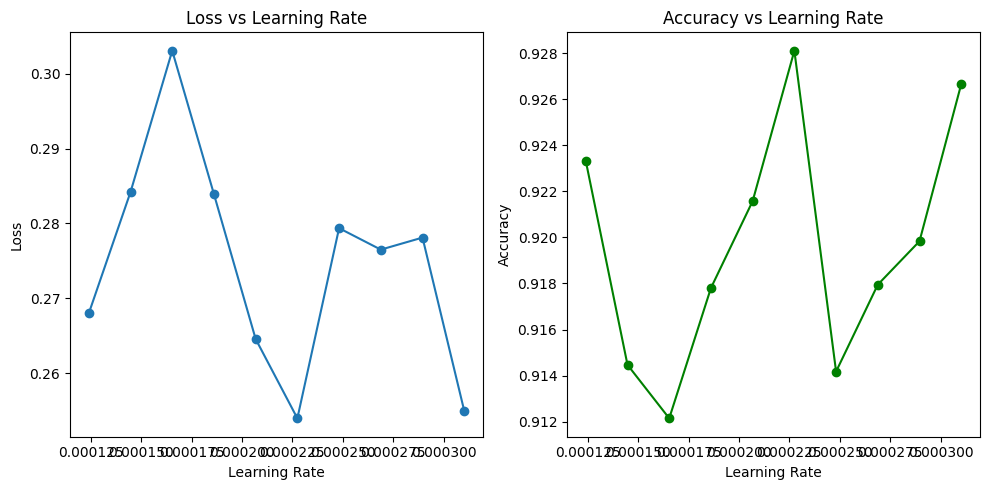

In [15]:
# Plot loss and accuracy vs learning rate
plt.figure(figsize=(10, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(lr_tab, loss_tab, marker='o', linestyle='-')
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.title("Loss vs Learning Rate")

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(lr_tab, acc_tab, marker='o', linestyle='-', color='g')
plt.xlabel("Learning Rate")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Learning Rate")

plt.tight_layout()
plt.show()

In [16]:
loss_tab.clear()
acc_tab.clear()
for i in batch_size_tab:
    config_batch = best_config.copy()
    config_batch["batch_size"] = i

    [loss, acc] = train_gpt2(config_batch, audio_dim, num_labels, device)
    loss_tab.append(loss)
    acc_tab.append(acc)

Epoch 1/5 - train loss: 0.8439 - train acc: 0.7505


Evaluating GPT2: 100%|██████████| 1722/1722 [00:15<00:00, 108.65it/s]


Epoch 1/5 - val loss: 0.4234 - val acc: 0.8814 - val prec: 0.8886 - val rec: 0.8837 - val f1: 0.8835
Epoch 2/5 - train loss: 0.3334 - train acc: 0.9003


Evaluating GPT2: 100%|██████████| 1722/1722 [00:15<00:00, 108.74it/s]


Epoch 2/5 - val loss: 0.3422 - val acc: 0.8978 - val prec: 0.9146 - val rec: 0.8980 - val f1: 0.9026
Epoch 3/5 - train loss: 0.2442 - train acc: 0.9274


Evaluating GPT2: 100%|██████████| 1722/1722 [00:15<00:00, 107.65it/s]


Epoch 3/5 - val loss: 0.2925 - val acc: 0.9113 - val prec: 0.9237 - val rec: 0.9092 - val f1: 0.9137
Epoch 4/5 - train loss: 0.1942 - train acc: 0.9413


Evaluating GPT2: 100%|██████████| 1722/1722 [00:15<00:00, 107.63it/s]


Epoch 4/5 - val loss: 0.2930 - val acc: 0.9079 - val prec: 0.8932 - val rec: 0.8808 - val f1: 0.8824
Epoch 5/5 - train loss: 0.1659 - train acc: 0.9496


Evaluating GPT2: 100%|██████████| 1722/1722 [00:15<00:00, 107.70it/s]


Epoch 5/5 - val loss: 0.2602 - val acc: 0.9251 - val prec: 0.9334 - val rec: 0.9264 - val f1: 0.9282


Evaluating GPT2: 100%|██████████| 1722/1722 [00:15<00:00, 107.81it/s]


Epoch 1/5 - train loss: 0.9838 - train acc: 0.7089


Evaluating GPT2: 100%|██████████| 431/431 [00:08<00:00, 49.19it/s]


Epoch 1/5 - val loss: 0.4566 - val acc: 0.8626 - val prec: 0.8797 - val rec: 0.8618 - val f1: 0.8656
Epoch 2/5 - train loss: 0.3207 - train acc: 0.9041


Evaluating GPT2: 100%|██████████| 431/431 [00:08<00:00, 49.05it/s]


Epoch 2/5 - val loss: 0.3363 - val acc: 0.9036 - val prec: 0.9179 - val rec: 0.9043 - val f1: 0.9086
Epoch 3/5 - train loss: 0.2304 - train acc: 0.9314


Evaluating GPT2: 100%|██████████| 431/431 [00:08<00:00, 50.26it/s]


Epoch 3/5 - val loss: 0.2709 - val acc: 0.9220 - val prec: 0.8992 - val rec: 0.8910 - val f1: 0.8940
Epoch 4/5 - train loss: 0.1793 - train acc: 0.9457


Evaluating GPT2: 100%|██████████| 431/431 [00:08<00:00, 50.30it/s]


Epoch 4/5 - val loss: 0.3267 - val acc: 0.9055 - val prec: 0.8885 - val rec: 0.8774 - val f1: 0.8796
Epoch 5/5 - train loss: 0.1457 - train acc: 0.9554


Evaluating GPT2: 100%|██████████| 431/431 [00:08<00:00, 50.27it/s]


Epoch 5/5 - val loss: 0.2728 - val acc: 0.9191 - val prec: 0.9277 - val rec: 0.9223 - val f1: 0.9226


Evaluating GPT2: 100%|██████████| 431/431 [00:08<00:00, 50.14it/s]


Epoch 1/5 - train loss: 1.1294 - train acc: 0.6716


Evaluating GPT2: 100%|██████████| 216/216 [00:08<00:00, 25.38it/s]


Epoch 1/5 - val loss: 0.5053 - val acc: 0.8530 - val prec: 0.8613 - val rec: 0.8567 - val f1: 0.8555
Epoch 2/5 - train loss: 0.3247 - train acc: 0.9036


Evaluating GPT2: 100%|██████████| 216/216 [00:08<00:00, 25.42it/s]


Epoch 2/5 - val loss: 0.3266 - val acc: 0.9042 - val prec: 0.9171 - val rec: 0.9042 - val f1: 0.9078
Epoch 3/5 - train loss: 0.2260 - train acc: 0.9316


Evaluating GPT2: 100%|██████████| 216/216 [00:08<00:00, 25.50it/s]


Epoch 3/5 - val loss: 0.2995 - val acc: 0.9104 - val prec: 0.9229 - val rec: 0.9101 - val f1: 0.9144
Epoch 4/5 - train loss: 0.1733 - train acc: 0.9486


Evaluating GPT2: 100%|██████████| 216/216 [00:08<00:00, 25.76it/s]


Epoch 4/5 - val loss: 0.2947 - val acc: 0.9126 - val prec: 0.9203 - val rec: 0.9143 - val f1: 0.9155
Epoch 5/5 - train loss: 0.1432 - train acc: 0.9563


Evaluating GPT2: 100%|██████████| 216/216 [00:08<00:00, 25.76it/s]


Epoch 5/5 - val loss: 0.2757 - val acc: 0.9210 - val prec: 0.9292 - val rec: 0.9226 - val f1: 0.9242


Evaluating GPT2: 100%|██████████| 216/216 [00:08<00:00, 25.68it/s]


Epoch 1/5 - train loss: 1.3565 - train acc: 0.6047


Evaluating GPT2: 100%|██████████| 108/108 [00:08<00:00, 13.16it/s]


Epoch 1/5 - val loss: 0.5159 - val acc: 0.8458 - val prec: 0.8617 - val rec: 0.8465 - val f1: 0.8497
Epoch 2/5 - train loss: 0.3369 - train acc: 0.9013


Evaluating GPT2: 100%|██████████| 108/108 [00:08<00:00, 13.07it/s]


Epoch 2/5 - val loss: 0.3337 - val acc: 0.8970 - val prec: 0.9061 - val rec: 0.8998 - val f1: 0.9006
Epoch 3/5 - train loss: 0.2194 - train acc: 0.9349


Evaluating GPT2: 100%|██████████| 108/108 [00:08<00:00, 13.15it/s]


Epoch 3/5 - val loss: 0.2983 - val acc: 0.9094 - val prec: 0.9192 - val rec: 0.9093 - val f1: 0.9123
Epoch 4/5 - train loss: 0.1635 - train acc: 0.9508


Evaluating GPT2: 100%|██████████| 108/108 [00:08<00:00, 13.13it/s]


Epoch 4/5 - val loss: 0.2948 - val acc: 0.9137 - val prec: 0.9227 - val rec: 0.9163 - val f1: 0.9178
Epoch 5/5 - train loss: 0.1267 - train acc: 0.9617


Evaluating GPT2: 100%|██████████| 108/108 [00:08<00:00, 13.14it/s]


Epoch 5/5 - val loss: 0.2683 - val acc: 0.9243 - val prec: 0.9309 - val rec: 0.9262 - val f1: 0.9276


Evaluating GPT2: 100%|██████████| 108/108 [00:08<00:00, 13.13it/s]


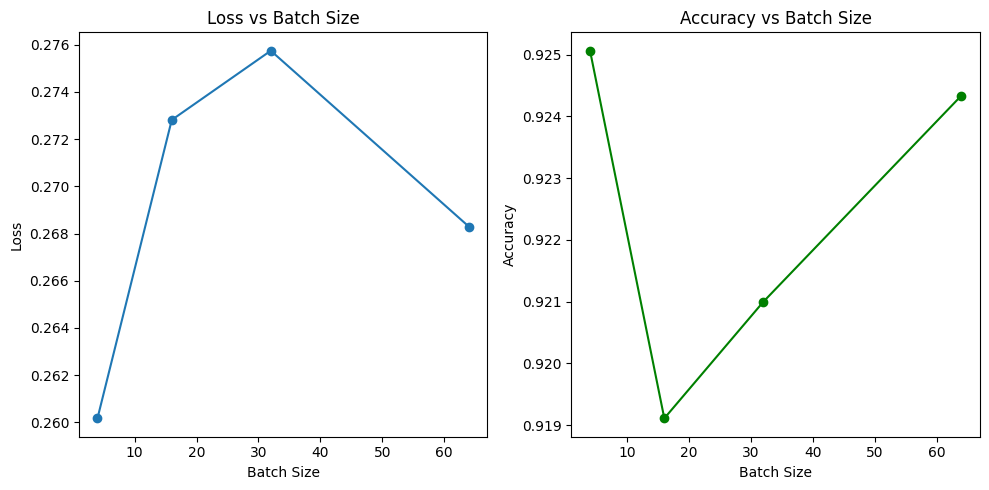

In [17]:
# Plot loss and accuracy vs learning rate
plt.figure(figsize=(10, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(batch_size_tab, loss_tab, marker='o', linestyle='-')
plt.xlabel("Batch Size")
plt.ylabel("Loss")
plt.title("Loss vs Batch Size")

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(batch_size_tab, acc_tab, marker='o', linestyle='-', color='g')
plt.xlabel("Batch Size")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Batch Size")

plt.tight_layout()
plt.show()

In [18]:
loss_tab.clear()
acc_tab.clear()
for i in epoch_tab:
    config_epoch = best_config.copy()
    config_epoch["epochs"] = i

    [loss, acc] = train_gpt2(config_epoch, audio_dim, num_labels, device)
    loss_tab.append(loss)
    acc_tab.append(acc)

Epoch 1/1 - train loss: 1.3633 - train acc: 0.6052


Evaluating GPT2: 100%|██████████| 108/108 [00:08<00:00, 13.14it/s]


Epoch 1/1 - val loss: 0.5486 - val acc: 0.8436 - val prec: 0.8529 - val rec: 0.8458 - val f1: 0.8472


Evaluating GPT2: 100%|██████████| 108/108 [00:08<00:00, 13.13it/s]


Epoch 1/3 - train loss: 1.5251 - train acc: 0.5588


Evaluating GPT2: 100%|██████████| 108/108 [00:08<00:00, 13.14it/s]


Epoch 1/3 - val loss: 0.6466 - val acc: 0.8172 - val prec: 0.8153 - val rec: 0.7900 - val f1: 0.7926
Epoch 2/3 - train loss: 0.3542 - train acc: 0.8962


Evaluating GPT2: 100%|██████████| 108/108 [00:08<00:00, 13.13it/s]


Epoch 2/3 - val loss: 0.3583 - val acc: 0.8941 - val prec: 0.8766 - val rec: 0.8667 - val f1: 0.8692
Epoch 3/3 - train loss: 0.2318 - train acc: 0.9322


Evaluating GPT2: 100%|██████████| 108/108 [00:08<00:00, 13.13it/s]


Epoch 3/3 - val loss: 0.2909 - val acc: 0.9152 - val prec: 0.9202 - val rec: 0.9177 - val f1: 0.9180


Evaluating GPT2: 100%|██████████| 108/108 [00:08<00:00, 13.14it/s]


Epoch 1/5 - train loss: 1.5702 - train acc: 0.5478


Evaluating GPT2: 100%|██████████| 108/108 [00:08<00:00, 13.14it/s]


Epoch 1/5 - val loss: 0.5461 - val acc: 0.8350 - val prec: 0.8517 - val rec: 0.8321 - val f1: 0.8367
Epoch 2/5 - train loss: 0.3626 - train acc: 0.8933


Evaluating GPT2: 100%|██████████| 108/108 [00:08<00:00, 13.14it/s]


Epoch 2/5 - val loss: 0.3771 - val acc: 0.8843 - val prec: 0.9010 - val rec: 0.8848 - val f1: 0.8876
Epoch 3/5 - train loss: 0.2375 - train acc: 0.9296


Evaluating GPT2: 100%|██████████| 108/108 [00:08<00:00, 13.16it/s]


Epoch 3/5 - val loss: 0.3005 - val acc: 0.9094 - val prec: 0.9195 - val rec: 0.9117 - val f1: 0.9136
Epoch 4/5 - train loss: 0.1735 - train acc: 0.9473


Evaluating GPT2: 100%|██████████| 108/108 [00:08<00:00, 13.13it/s]


Epoch 4/5 - val loss: 0.2722 - val acc: 0.9219 - val prec: 0.9311 - val rec: 0.9235 - val f1: 0.9256
Epoch 5/5 - train loss: 0.1357 - train acc: 0.9602


Evaluating GPT2: 100%|██████████| 108/108 [00:08<00:00, 13.12it/s]


Epoch 5/5 - val loss: 0.2670 - val acc: 0.9220 - val prec: 0.9254 - val rec: 0.9241 - val f1: 0.9241


Evaluating GPT2: 100%|██████████| 108/108 [00:08<00:00, 13.12it/s]


Epoch 1/7 - train loss: 1.5577 - train acc: 0.5537


Evaluating GPT2: 100%|██████████| 108/108 [00:08<00:00, 13.15it/s]


Epoch 1/7 - val loss: 0.5299 - val acc: 0.8497 - val prec: 0.8578 - val rec: 0.8525 - val f1: 0.8521
Epoch 2/7 - train loss: 0.3613 - train acc: 0.8941


Evaluating GPT2: 100%|██████████| 108/108 [00:08<00:00, 13.13it/s]


Epoch 2/7 - val loss: 0.3235 - val acc: 0.9044 - val prec: 0.8831 - val rec: 0.8751 - val f1: 0.8772
Epoch 3/7 - train loss: 0.2322 - train acc: 0.9307


Evaluating GPT2: 100%|██████████| 108/108 [00:08<00:00, 13.14it/s]


Epoch 3/7 - val loss: 0.3066 - val acc: 0.9087 - val prec: 0.8850 - val rec: 0.8814 - val f1: 0.8816
Epoch 4/7 - train loss: 0.1728 - train acc: 0.9495


Evaluating GPT2: 100%|██████████| 108/108 [00:08<00:00, 13.13it/s]


Epoch 4/7 - val loss: 0.2603 - val acc: 0.9265 - val prec: 0.9024 - val rec: 0.8985 - val f1: 0.8997
Epoch 5/7 - train loss: 0.1390 - train acc: 0.9578


Evaluating GPT2: 100%|██████████| 108/108 [00:08<00:00, 13.12it/s]


Epoch 5/7 - val loss: 0.2927 - val acc: 0.9164 - val prec: 0.9236 - val rec: 0.9191 - val f1: 0.9197
Epoch 6/7 - train loss: 0.1100 - train acc: 0.9665


Evaluating GPT2: 100%|██████████| 108/108 [00:08<00:00, 13.14it/s]


Epoch 6/7 - val loss: 0.2661 - val acc: 0.9242 - val prec: 0.9015 - val rec: 0.8952 - val f1: 0.8971
Epoch 7/7 - train loss: 0.0946 - train acc: 0.9717


Evaluating GPT2: 100%|██████████| 108/108 [00:08<00:00, 13.13it/s]


Epoch 7/7 - val loss: 0.3010 - val acc: 0.9188 - val prec: 0.8943 - val rec: 0.8911 - val f1: 0.8912


Evaluating GPT2: 100%|██████████| 108/108 [00:08<00:00, 13.11it/s]


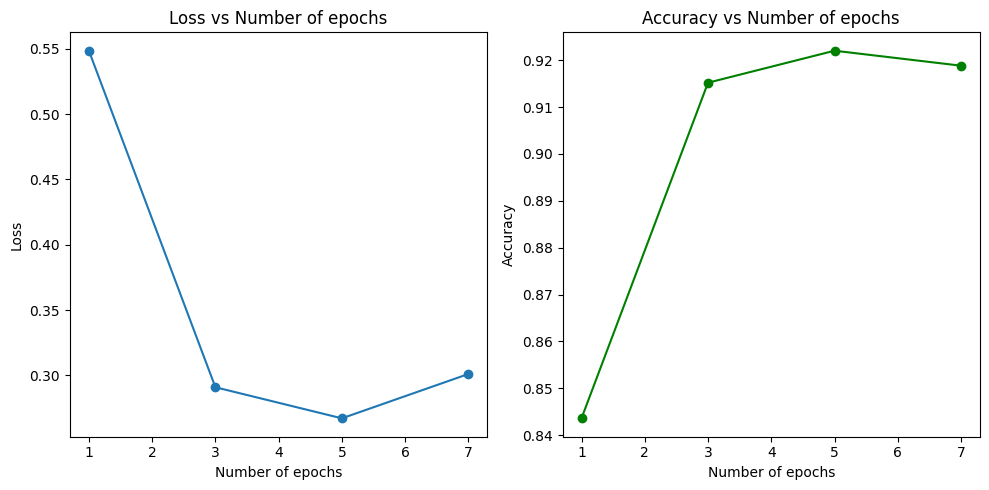

In [19]:
# Plot loss and accuracy vs learning rate
plt.figure(figsize=(10, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(epoch_tab, loss_tab, marker='o', linestyle='-')
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.title("Loss vs Number of epochs")

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(epoch_tab, acc_tab, marker='o', linestyle='-', color='g')
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Number of epochs")

plt.tight_layout()
plt.show()

In [20]:
model = GPT2FineTuner(
    audio_dim=audio_dim,
    num_labels=num_labels,
    pretrained=True,
    model_name="gpt2",
    lr=5e-5
).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

In [21]:
# training loop
# takes long time for gpt2...
model.train_architecture(train_loader = train_loader, epochs = 1)

Epoch 1/1 - train loss: 2.5424 - train acc: 0.2685


In [22]:
results = model.evaluate(test_loader)
print("Validation Summary:")
for k, v in results['summary'].items():
    print(f"  {k}: {v:.4f}")

Evaluating GPT2: 100%|██████████| 108/108 [00:08<00:00, 13.01it/s]

Validation Summary:
  loss: 1.1516
  accuracy: 0.6599
  precision: 0.6811
  recall: 0.6569
  f1: 0.6558


## More automated approach to running tests
Running tests throgh an automated Experiment Object created through ExperimentFactory for easy and streamlined experiments.

In [23]:
from DataObjects.Experiments import ExperimentFactory, GPT2Experiment

In [24]:
# set device to cuda
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [25]:
gpt2_exp = ExperimentFactory.create_experiment(
    arch_name='gpt2',
    train_dir='Data/MFCC_transformed/training',
    val_dir='Data/MFCC_transformed/validation',
    test_dir='Data/MFCC_transformed/testing',
    batch_size=32,
    epochs=5,
    audio_dim=128,
    save_path = "Saved_experimented_data/GPT2_experiment.txt",     
    model_kwargs={
        'num_labels': 31,
        'pretrained': False,
        'model_name': 'gpt2',
        'lr': 5e-5
    }
)

In [26]:
gpt2_exp.run()

ZeroDivisionError: float division by zero